# Generative Adversarial Networks for MNIST Dataset

This notebook shows the process of building a neural network that learns to generate handwritten digits.

## Introduction 

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread.” Sliced bread certainly never created this much excitement within the deep learning community. Generative adversarial networks—or GANs, for short—have dramatically sharpened the possibility of AI-generated content, and have drawn active research efforts since they were [first described by Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661).  
GANs are neural networks that learn to create synthetic data similar to some known input data.

We'll build a GAN that analyzes lots of images of handwritten digits and gradually learns to generate new images from scratch—essentially.   
We'll be teaching a neural network how to write.

## GAN architecture

Generative adversarial networks consist of two models: a **generative model** and a **discriminative model**.  
![1](image/1.PNG)  


The **discriminator model** is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The **generator model** takes random input values and transforms them into images through a deconvolutional neural network.

Over many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation.   
The ***discriminator*** learns to tell "**real**" images of handwritten digits apart from "**fake**" images created by the generator.    
At the same time, the ***generator*** uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## Implementation

I am going to implement GAN for MNOST dataset by using Tensorflow.  
  
We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

### Import the packages

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


# Load MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The MNIST variable we created above contains both the images and their labels, divided into a training set called train and a validation set called validation.  
  
We can retrieve batches of images by calling ***next_batch*** on mnist. Let's load one image and look at it.  
  
The images are initially formatted as a single row of 784 pixels. We can reshape them into 28 x 28-pixel images and view them using ***pyplot***.

(1, 784)


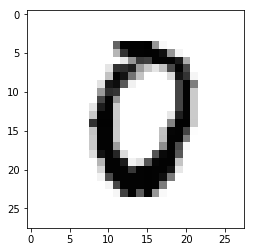

In [3]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

### Discriminator network

Our discriminator is a ***convolutional neural network*** that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.  
![2](image/2.png)

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/tutorials/layers). It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.  
  
To set up each layer, we start by creating weight and bias variables through [tf.get_variable](https://www.tensorflow.org/api_docs/python/tf/get_variable). Weights are initialized from a [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) distribution, and biases are initialized at zero.  
  
[tf.nn.conv2d()](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our 28 x 28 x 1 images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

In [4]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

### Generator network


![3](image/3.png)

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea](https://github.com/osh/KerasGAN).  
  
You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a d-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer.  
  
In our generator network, we use three convolutional layers along with interpolation until a 28 x 28 pixel image is formed. (Actually, as you'll see below, we've taken care to form 28 x 28 x 1 images; many TensorFlow tools for dealing with images anticipate that the images will have some number of channels—usually 1 for greyscale images or 3 for RGB color images.)  
  
At the output layer, we add a [tf.sigmoid()](https://www.tensorflow.org/api_docs/python/tf/sigmoid) activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

In [5]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

## Generating a sample image

Now we’ve defined both the generator and discriminator functions. Let’s see what a sample output from an untrained generator looks like.  
  
We need to open a TensorFlow session and create a placeholder for the input to our generator. The shape of the placeholder will be None, z_dimensions. The None keyword means that the value can be determined at session runtime. We normally have None as our first dimension so that we can have variable batch sizes. (With a batch size of 50, the input to the generator would be 50 x 100). With the None keywoard, we don't have to specify batch_size until later.

In [6]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])


Now, we create a variable (generated_image_output) that holds the output of the generator, and we'll also initialize the random noise vector that we're going to use as input. The [np.random.normal()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) function has three arguments. The first and second define the mean and standard deviation for the normal distribution (0 and 1 in our case), and the third defines the the shape of the vector (1 x 100).  


In [7]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Next, we initialize all the variables, feed our z_batch into the placeholder, and run the session.  
  
The [sess.run()](https://www.tensorflow.org/api_docs/python/tf/Session#run) function has two arguments. The first is called the "fetches" argument; it defines the value you're interested in computing. In our case, we want to see what the output of the generator is. If you look back at the last code snippet, you'll see that the output of the generator function is stored in generated_image_output, so we'll use generated_image_output for our first argument.  
  
The second argument takes a dictionary of inputs that are substituted into the graph when it runs. This is where we feed in our placeholders. In our example, we need to feed our z_batch variable into the z_placeholder that we defined earlier. As before, we'll view the image by reshaping it to 28 x 28 pixels and show it with PyPlot.

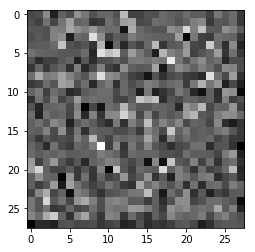

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

That looks like noise.  
Now we need to train the weights and biases in the generator network to convert random numbers into recognizable digits.

## Training a GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.  
  
We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.  
  
Here are the inputs and outputs for our networks.

In [9]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

So, let’s first think about what we want out of our networks. The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator: one loss that compares Dx and 1 for real images from the MNIST set, as well as a loss that compares Dg and 0 for images from the generator. We'll do this with TensorFlow's [tf.nn.sigmoid_cross_entropy_with_logits()](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function, which calculates the cross-entropy losses between Dx and 1 and between Dg and 0.  
  
***sigmoid_cross_entropy_with_logits*** operates on unscaled values rather than probability values from 0 to 1. Take a look at the last line of our discriminator: there's no softmax or sigmoid layer at the end. GANs can fail if their discriminators "saturate," or become confident enough to return exactly 0 when they're given a generated image; that leaves the discriminator without a useful gradient to descend.  
  
The [tf.reduce_mean()](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [10]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Then, set up the generator's loss function.   
We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator. Therefore, we want to compute the loss between Dg and 1.

In [11]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

We have our loss functions now, and we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.  
  

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [12]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_b1/beta:0', 'g_w2:0', 'g_b2:0', 'g_b2/beta:0', 'g_w3:0', 'g_b3:0', 'g_b3/beta:0', 'g_w4:0', 'g_b4:0']


Next, we specify our two optimizers. [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.  
  
We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to regulate learning in other ways.

In [13]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)


It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.  
  
If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run  
tensorboard --logdir=tensorboard/  
  
and open TensorBoard by visiting http://localhost:6006 in your web browser.

In [14]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

Now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.  
  
Then, we move on to the main training loop. When we train the generator, we’ll feed a random z vector into the generator and pass its output to the discriminator (this is the Dg variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.  
  
To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.  
  
**The following cell would take some hours.**

dLossReal: 0.695033 dLossFake: 0.690488
dLossReal: 0.0258674 dLossFake: 0.0321199
dLossReal: 0.00502321 dLossFake: 0.00386407
Iteration: 0 at 2018-02-23 17:19:33.988709


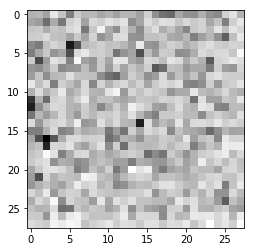

Estimate: [[-8.75225258]]
Iteration: 100 at 2018-02-23 17:19:45.523242


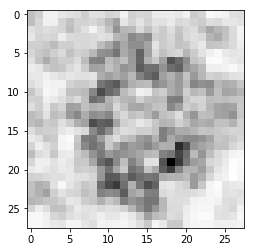

Estimate: [[-7.09925318]]
Iteration: 200 at 2018-02-23 17:19:56.603820


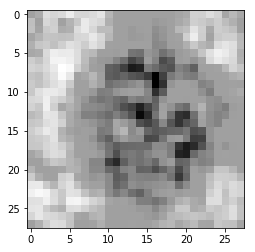

Estimate: [[-6.35915089]]
Iteration: 300 at 2018-02-23 17:20:07.741211


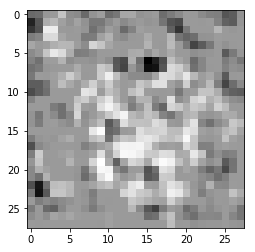

Estimate: [[-8.05366135]]
Iteration: 400 at 2018-02-23 17:20:18.996310


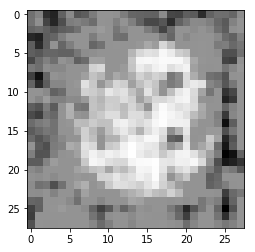

Estimate: [[-6.64384699]]
Iteration: 500 at 2018-02-23 17:20:30.209092


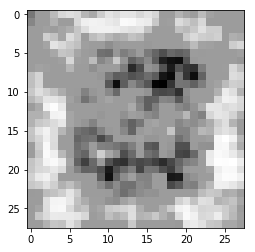

Estimate: [[-6.66607046]]
Iteration: 600 at 2018-02-23 17:20:41.322369


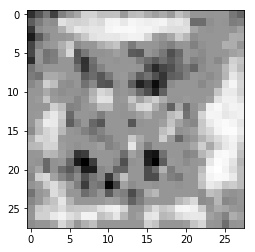

Estimate: [[-9.2730732]]
Iteration: 700 at 2018-02-23 17:20:52.441950


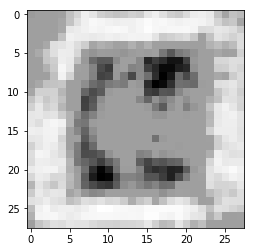

Estimate: [[-6.78864193]]
Iteration: 800 at 2018-02-23 17:21:03.647616


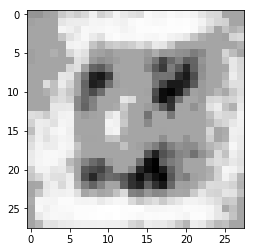

Estimate: [[-6.75576258]]
Iteration: 900 at 2018-02-23 17:21:14.810192


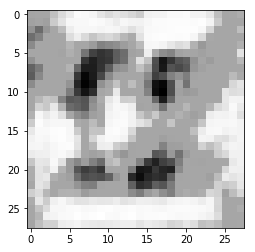

Estimate: [[-5.84403229]]
Iteration: 1000 at 2018-02-23 17:21:25.950943


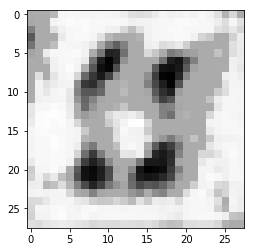

Estimate: [[-6.31838274]]
Iteration: 1100 at 2018-02-23 17:21:37.462236


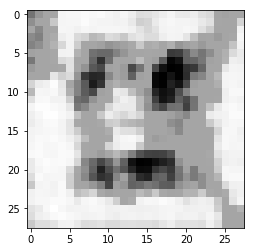

Estimate: [[ 2.67334843]]
Iteration: 1200 at 2018-02-23 17:21:48.722939


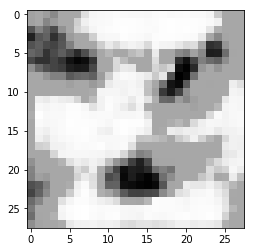

Estimate: [[-6.36151266]]
Iteration: 1300 at 2018-02-23 17:21:59.934486


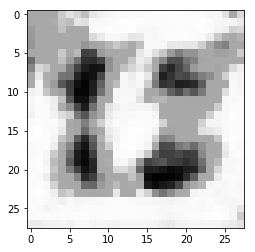

Estimate: [[-5.0060997]]
Iteration: 1400 at 2018-02-23 17:22:11.080252


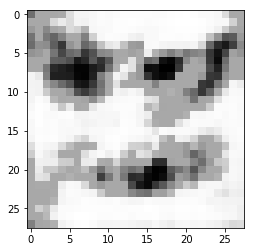

Estimate: [[-6.17757893]]
Iteration: 1500 at 2018-02-23 17:22:22.274850


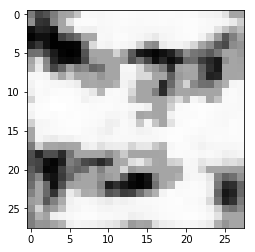

Estimate: [[-3.42001033]]
Iteration: 1600 at 2018-02-23 17:22:33.391253


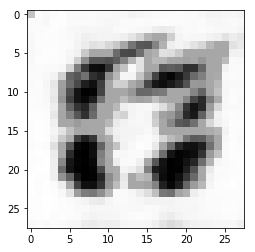

Estimate: [[ 22.75860596]]
Iteration: 1700 at 2018-02-23 17:22:44.588624


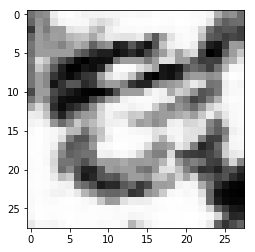

Estimate: [[-5.33480597]]
Iteration: 1800 at 2018-02-23 17:22:55.856577


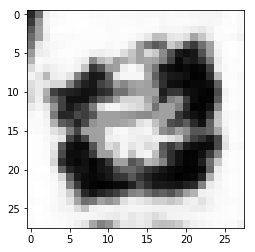

Estimate: [[-3.90473819]]
Iteration: 1900 at 2018-02-23 17:23:07.106092


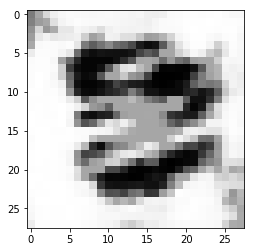

Estimate: [[-3.60739517]]
Iteration: 2000 at 2018-02-23 17:23:18.304902


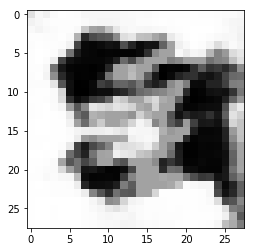

Estimate: [[-6.97490644]]
Iteration: 2100 at 2018-02-23 17:23:29.533239


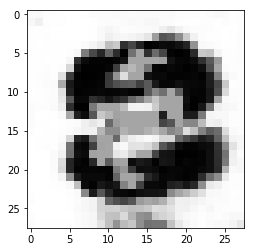

Estimate: [[-7.27503824]]
Iteration: 2200 at 2018-02-23 17:23:40.830909


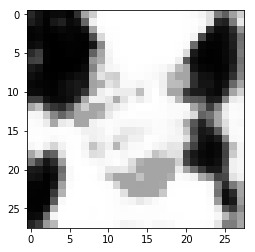

Estimate: [[-10.38442993]]
Iteration: 2300 at 2018-02-23 17:23:52.180105


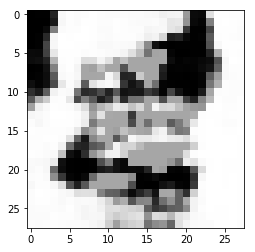

Estimate: [[-6.02541494]]
Iteration: 2400 at 2018-02-23 17:24:03.386869


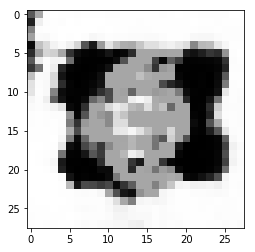

Estimate: [[-4.61579847]]
Iteration: 2500 at 2018-02-23 17:24:14.620338


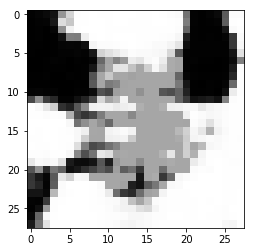

Estimate: [[-13.09088898]]
Iteration: 2600 at 2018-02-23 17:24:25.860218


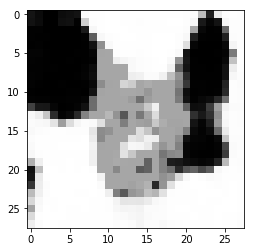

Estimate: [[-3.50716281]]
Iteration: 2700 at 2018-02-23 17:24:37.111907


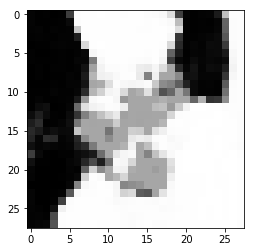

Estimate: [[-4.25072908]]
Iteration: 2800 at 2018-02-23 17:24:48.294998


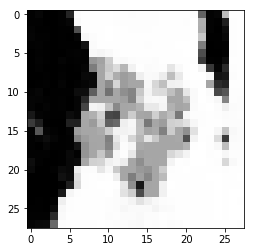

Estimate: [[-5.8851347]]
Iteration: 2900 at 2018-02-23 17:24:59.558284


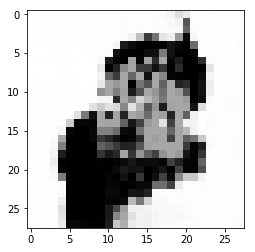

Estimate: [[-4.02819967]]
Iteration: 3000 at 2018-02-23 17:25:10.970449


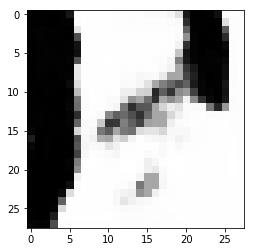

Estimate: [[-4.59027052]]
Iteration: 3100 at 2018-02-23 17:25:22.128060


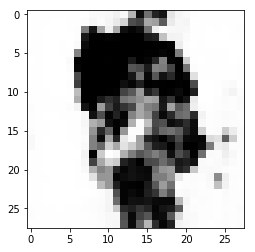

Estimate: [[-7.17013264]]
Iteration: 3200 at 2018-02-23 17:25:33.321322


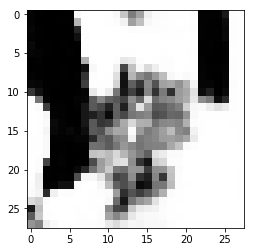

Estimate: [[-4.76378679]]
Iteration: 3300 at 2018-02-23 17:25:44.780924


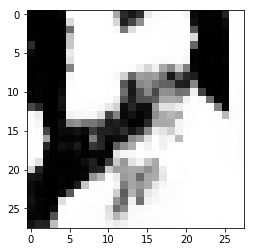

Estimate: [[-5.74592543]]
Iteration: 3400 at 2018-02-23 17:25:56.157081


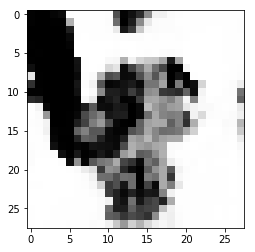

Estimate: [[-4.44166183]]
Iteration: 3500 at 2018-02-23 17:26:07.313133


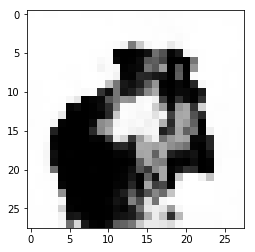

Estimate: [[-2.55351758]]
Iteration: 3600 at 2018-02-23 17:26:18.451479


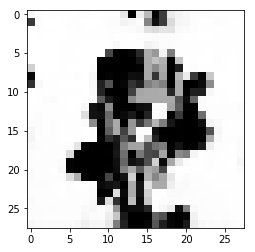

Estimate: [[-15.95219231]]
Iteration: 3700 at 2018-02-23 17:26:29.773633


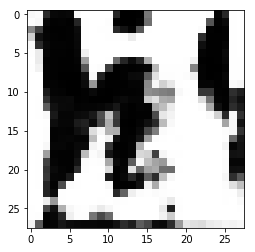

Estimate: [[-13.98874855]]
Iteration: 3800 at 2018-02-23 17:26:41.050791


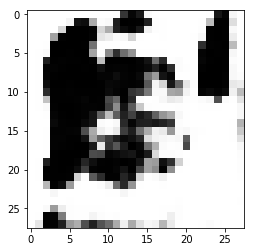

Estimate: [[-10.29559422]]
Iteration: 3900 at 2018-02-23 17:26:52.278738


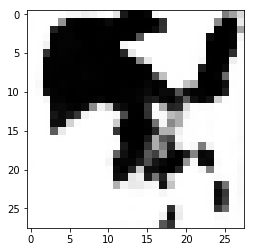

Estimate: [[-10.52779865]]
Iteration: 4000 at 2018-02-23 17:27:03.459631


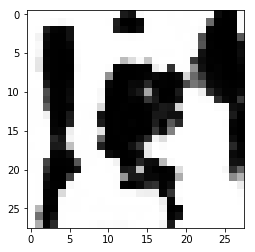

Estimate: [[ 1.91001678]]
Iteration: 4100 at 2018-02-23 17:27:14.925679


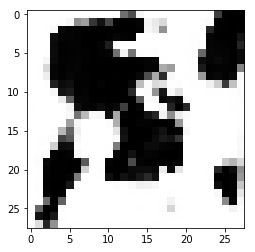

Estimate: [[-9.64020348]]
Iteration: 4200 at 2018-02-23 17:27:26.150922


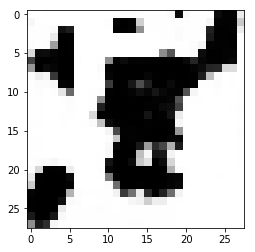

Estimate: [[ 0.9559592]]
Iteration: 4300 at 2018-02-23 17:27:37.529155


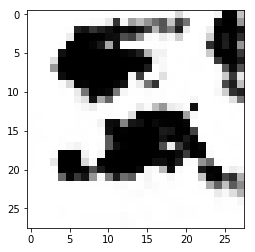

Estimate: [[-3.21756768]]
Iteration: 4400 at 2018-02-23 17:27:48.764195


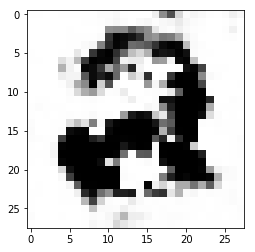

Estimate: [[-0.48550373]]
Iteration: 4500 at 2018-02-23 17:28:00.038857


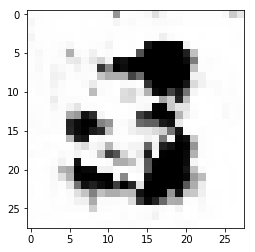

Estimate: [[-0.92487836]]
Iteration: 4600 at 2018-02-23 17:28:11.267111


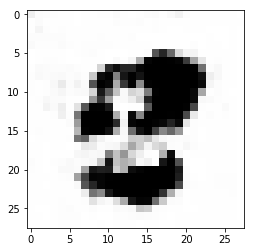

Estimate: [[-0.85891616]]
Iteration: 4700 at 2018-02-23 17:28:22.589678


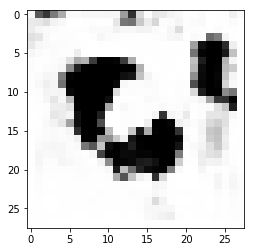

Estimate: [[-0.35070986]]
Iteration: 4800 at 2018-02-23 17:28:33.884827


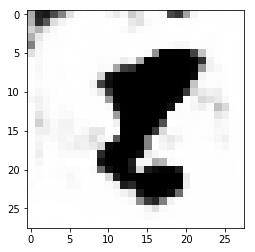

Estimate: [[-0.19189161]]
Iteration: 4900 at 2018-02-23 17:28:45.221871


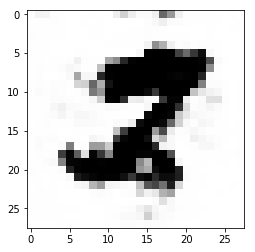

Estimate: [[-0.39582354]]
Iteration: 5000 at 2018-02-23 17:28:56.635230


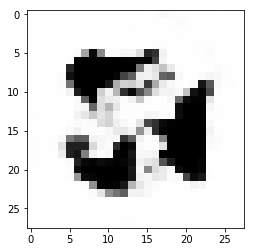

Estimate: [[ 0.15853193]]
Iteration: 5100 at 2018-02-23 17:29:07.992474


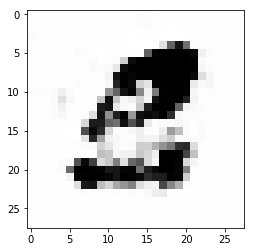

Estimate: [[-1.74681008]]
Iteration: 5200 at 2018-02-23 17:29:19.595401


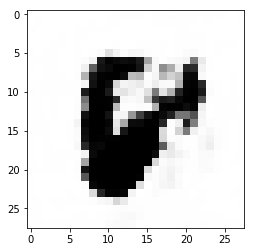

Estimate: [[-1.05818605]]
Iteration: 5300 at 2018-02-23 17:29:30.949292


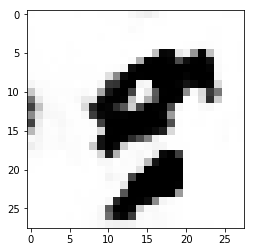

Estimate: [[-2.07689452]]
Iteration: 5400 at 2018-02-23 17:29:42.435172


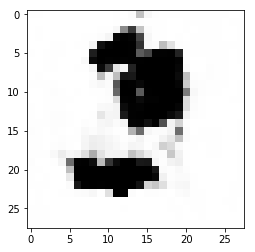

Estimate: [[-0.22772706]]
Iteration: 5500 at 2018-02-23 17:29:53.818248


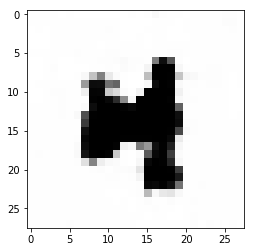

Estimate: [[-0.78666866]]
Iteration: 5600 at 2018-02-23 17:30:05.129620


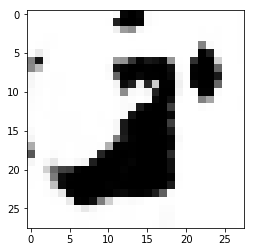

Estimate: [[-1.08008862]]
Iteration: 5700 at 2018-02-23 17:30:16.445911


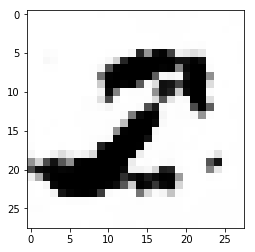

Estimate: [[-2.00341463]]
Iteration: 5800 at 2018-02-23 17:30:27.972321


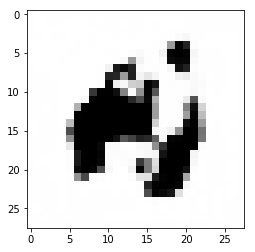

Estimate: [[-1.21893895]]
Iteration: 5900 at 2018-02-23 17:30:39.418708


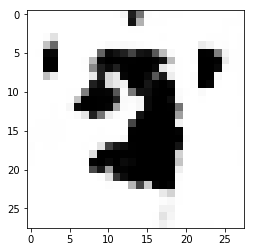

Estimate: [[-1.02671409]]
Iteration: 6000 at 2018-02-23 17:30:50.648805


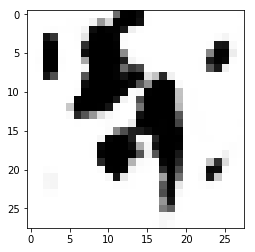

Estimate: [[-1.81816614]]
Iteration: 6100 at 2018-02-23 17:31:01.951214


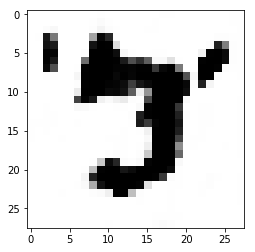

Estimate: [[-0.88423419]]
Iteration: 6200 at 2018-02-23 17:31:13.280193


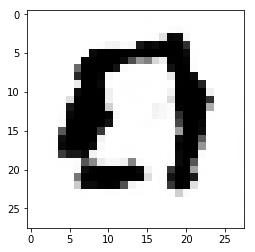

Estimate: [[ 1.71642172]]
Iteration: 6300 at 2018-02-23 17:31:24.763510


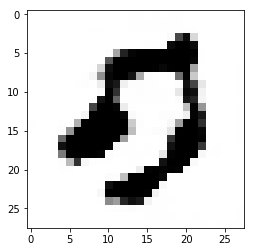

Estimate: [[-0.57485741]]
Iteration: 6400 at 2018-02-23 17:31:36.265104


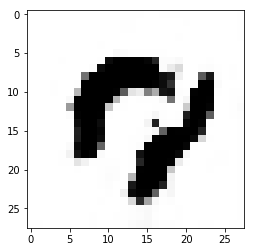

Estimate: [[ 1.93555367]]
Iteration: 6500 at 2018-02-23 17:31:47.810882


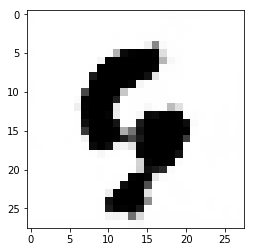

Estimate: [[ 0.48285496]]
Iteration: 6600 at 2018-02-23 17:31:59.187710


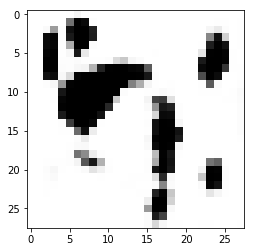

Estimate: [[-2.14049029]]
Iteration: 6700 at 2018-02-23 17:32:10.513608


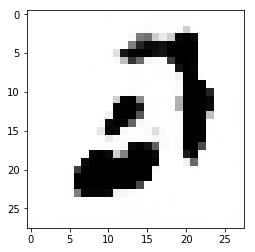

Estimate: [[-0.86589396]]
Iteration: 6800 at 2018-02-23 17:32:21.815565


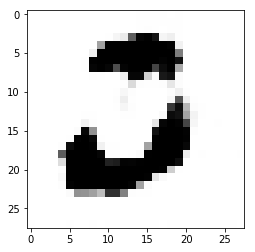

Estimate: [[-0.26316479]]
Iteration: 6900 at 2018-02-23 17:32:33.152444


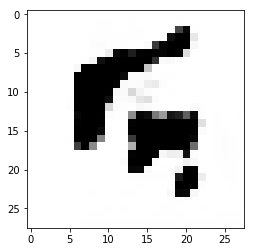

Estimate: [[ 1.30007243]]
Iteration: 7000 at 2018-02-23 17:32:44.480741


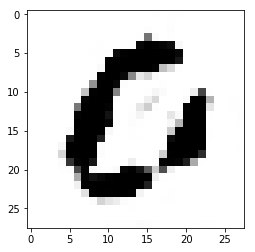

Estimate: [[-0.54510939]]
Iteration: 7100 at 2018-02-23 17:32:55.840786


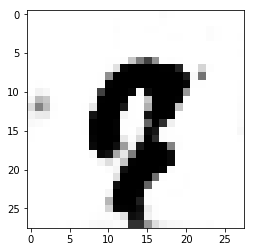

Estimate: [[-0.04034995]]
Iteration: 7200 at 2018-02-23 17:33:07.201355


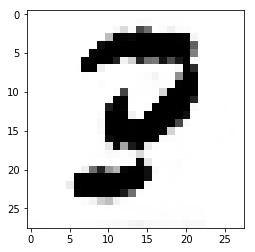

Estimate: [[ 0.58919054]]
Iteration: 7300 at 2018-02-23 17:33:18.506962


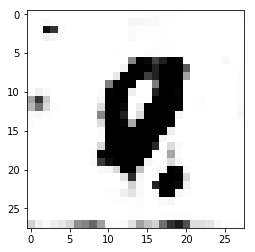

Estimate: [[-1.75901783]]
Iteration: 7400 at 2018-02-23 17:33:30.219978


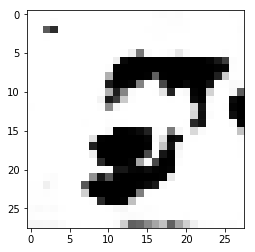

Estimate: [[-1.19221258]]
Iteration: 7500 at 2018-02-23 17:33:41.580175


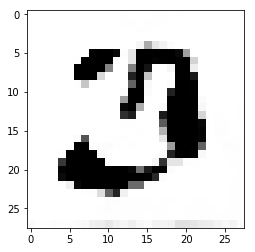

Estimate: [[ 0.06968876]]
Iteration: 7600 at 2018-02-23 17:33:52.820713


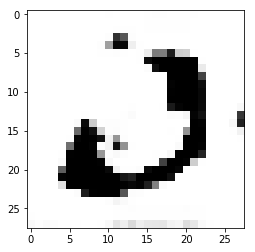

Estimate: [[-0.37979889]]
Iteration: 7700 at 2018-02-23 17:34:04.152032


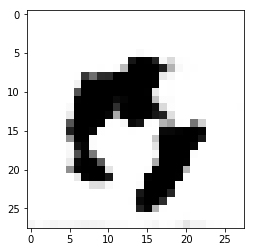

Estimate: [[ 0.08035185]]
Iteration: 7800 at 2018-02-23 17:34:15.544383


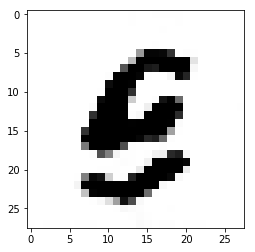

Estimate: [[ 0.15920347]]
Iteration: 7900 at 2018-02-23 17:34:26.985679


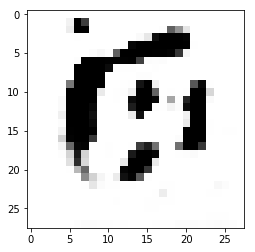

Estimate: [[-1.33447134]]
Iteration: 8000 at 2018-02-23 17:34:38.334530


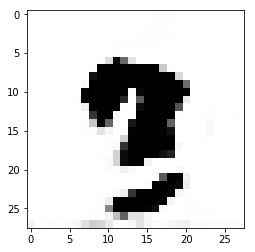

Estimate: [[-0.6618036]]
Iteration: 8100 at 2018-02-23 17:34:49.887184


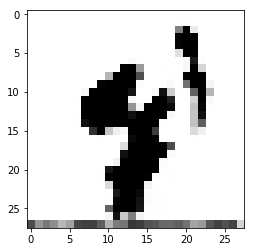

Estimate: [[-0.95552832]]
Iteration: 8200 at 2018-02-23 17:35:01.559427


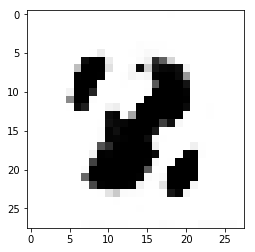

Estimate: [[ 0.04171906]]
Iteration: 8300 at 2018-02-23 17:35:12.878033


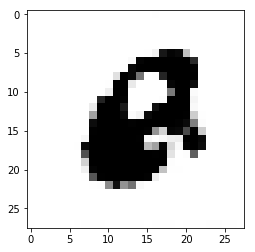

Estimate: [[ 0.36606753]]
Iteration: 8400 at 2018-02-23 17:35:24.333594


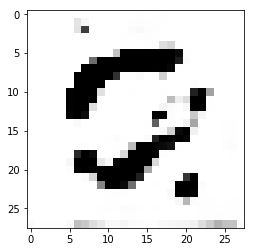

Estimate: [[-1.30064893]]
Iteration: 8500 at 2018-02-23 17:35:35.781185


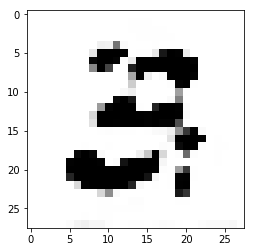

Estimate: [[-0.14552629]]
Iteration: 8600 at 2018-02-23 17:35:47.234042


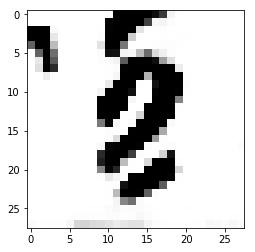

Estimate: [[ 1.99131584]]
Iteration: 8700 at 2018-02-23 17:35:58.713106


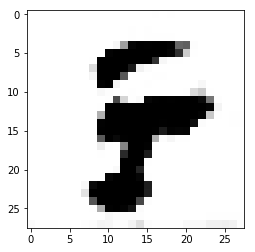

Estimate: [[ 0.30978823]]
Iteration: 8800 at 2018-02-23 17:36:10.237835


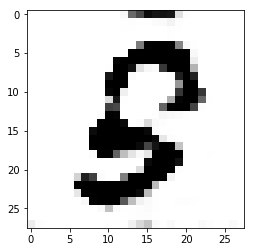

Estimate: [[ 0.29806077]]
Iteration: 8900 at 2018-02-23 17:36:21.712507


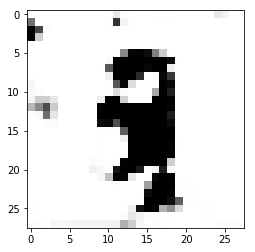

Estimate: [[-0.67455751]]
Iteration: 9000 at 2018-02-23 17:36:33.253599


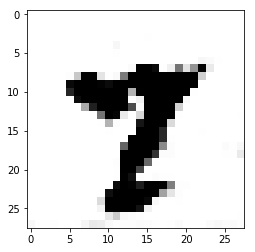

Estimate: [[ 0.24047449]]
Iteration: 9100 at 2018-02-23 17:36:44.594274


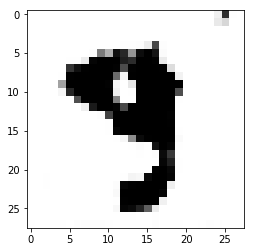

Estimate: [[-0.64938802]]
Iteration: 9200 at 2018-02-23 17:36:56.206790


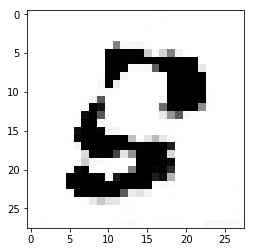

Estimate: [[-0.96371323]]
Iteration: 9300 at 2018-02-23 17:37:07.587193


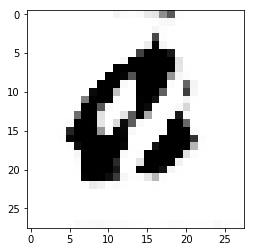

Estimate: [[-0.81983179]]
Iteration: 9400 at 2018-02-23 17:37:18.937448


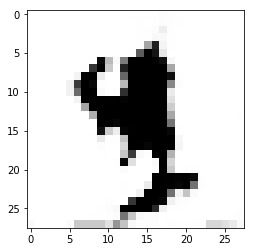

Estimate: [[-0.98791707]]
Iteration: 9500 at 2018-02-23 17:37:30.296559


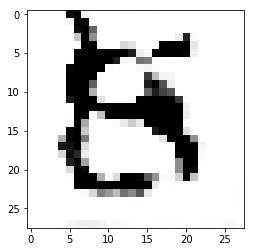

Estimate: [[-0.17716096]]
Iteration: 9600 at 2018-02-23 17:37:42.010108


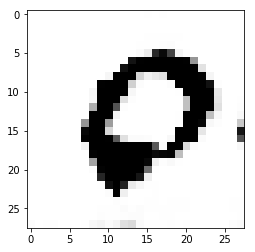

Estimate: [[ 1.37760603]]
Iteration: 9700 at 2018-02-23 17:37:53.737283


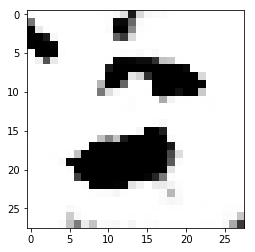

Estimate: [[-1.4462769]]
Iteration: 9800 at 2018-02-23 17:38:05.193735


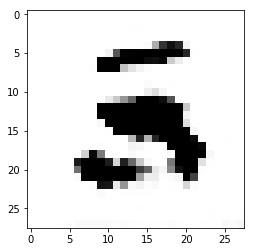

Estimate: [[-0.13579805]]
Iteration: 9900 at 2018-02-23 17:38:16.699320


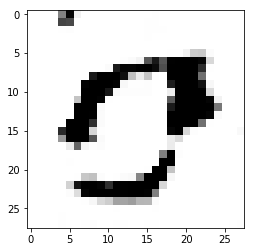

Estimate: [[-0.21109441]]
Iteration: 10000 at 2018-02-23 17:38:28.175828


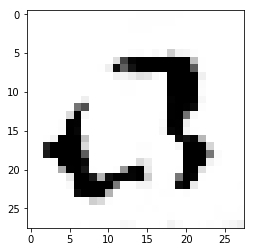

Estimate: [[-0.79007572]]
Iteration: 10100 at 2018-02-23 17:38:39.713498


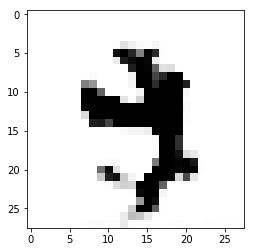

Estimate: [[-1.20083976]]
Iteration: 10200 at 2018-02-23 17:38:51.290271


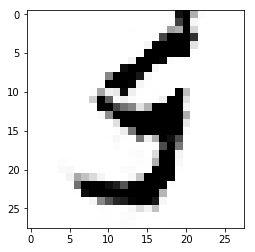

Estimate: [[ 0.30745506]]
Iteration: 10300 at 2018-02-23 17:39:02.765777


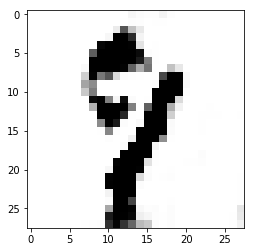

Estimate: [[-0.18152951]]
Iteration: 10400 at 2018-02-23 17:39:14.349582


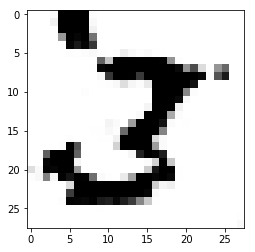

Estimate: [[ 0.00800849]]
Iteration: 10500 at 2018-02-23 17:39:25.964444


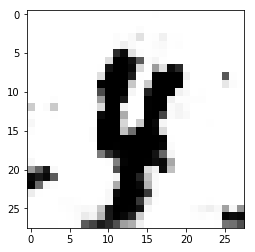

Estimate: [[-1.0369215]]
Iteration: 10600 at 2018-02-23 17:39:37.434936


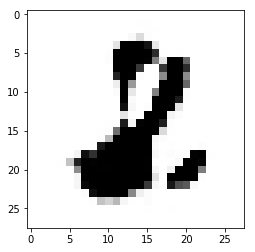

Estimate: [[-0.74651361]]
Iteration: 10700 at 2018-02-23 17:39:49.059838


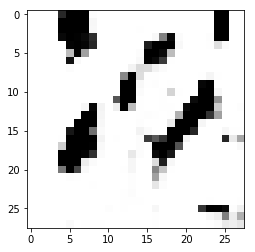

Estimate: [[ 1.0873456]]
Iteration: 10800 at 2018-02-23 17:40:00.592494


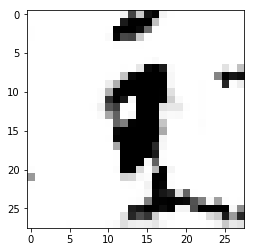

Estimate: [[-0.36302811]]
Iteration: 10900 at 2018-02-23 17:40:12.085044


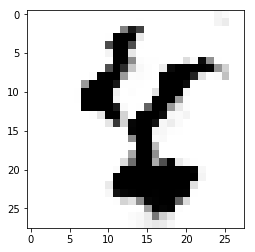

Estimate: [[-0.34855109]]
Iteration: 11000 at 2018-02-23 17:40:23.597647


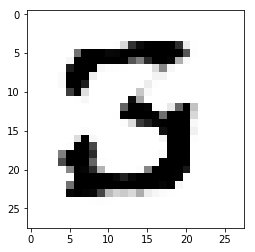

Estimate: [[-0.07936752]]
Iteration: 11100 at 2018-02-23 17:40:35.475222


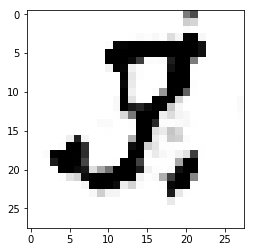

Estimate: [[-1.16281438]]
Iteration: 11200 at 2018-02-23 17:40:47.052998


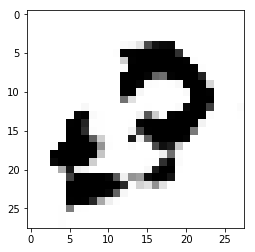

Estimate: [[-0.382577]]
Iteration: 11300 at 2018-02-23 17:40:58.819276


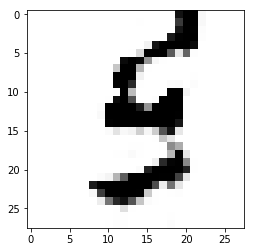

Estimate: [[-0.12847865]]
Iteration: 11400 at 2018-02-23 17:41:10.461037


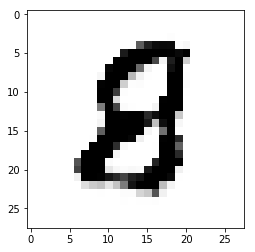

Estimate: [[ 0.50264227]]
Iteration: 11500 at 2018-02-23 17:41:21.974084


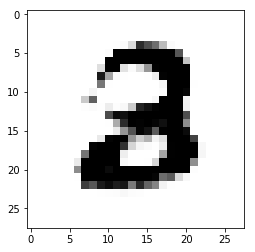

Estimate: [[-0.58252954]]
Iteration: 11600 at 2018-02-23 17:41:33.625491


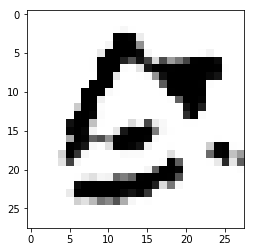

Estimate: [[-0.19675404]]
Iteration: 11700 at 2018-02-23 17:41:45.227735


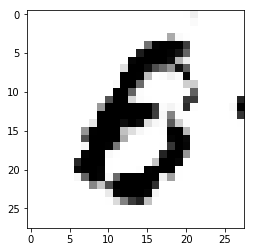

Estimate: [[-0.63472122]]
Iteration: 11800 at 2018-02-23 17:41:56.961934


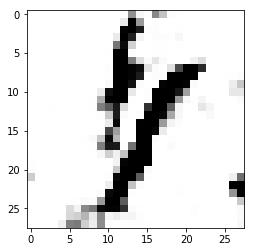

Estimate: [[ 0.43423891]]
Iteration: 11900 at 2018-02-23 17:42:08.644837


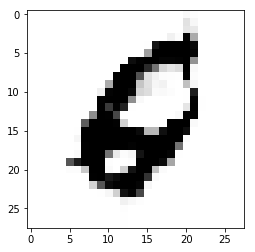

Estimate: [[-0.30343246]]
Iteration: 12000 at 2018-02-23 17:42:20.331804


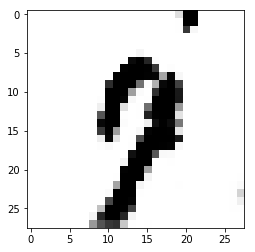

Estimate: [[-0.81355244]]
Iteration: 12100 at 2018-02-23 17:42:31.916233


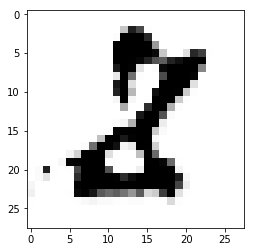

Estimate: [[-0.58444989]]
Iteration: 12200 at 2018-02-23 17:42:43.420375


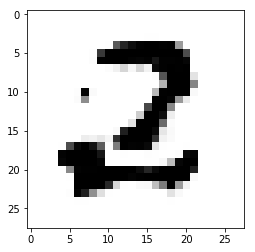

Estimate: [[ 1.06469238]]
Iteration: 12300 at 2018-02-23 17:42:55.018617


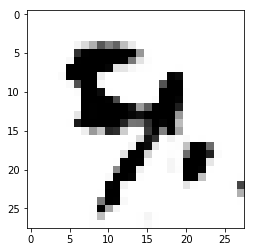

Estimate: [[-0.1402414]]
Iteration: 12400 at 2018-02-23 17:43:06.683097


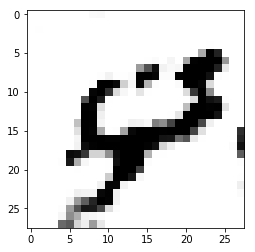

Estimate: [[-0.35662782]]
Iteration: 12500 at 2018-02-23 17:43:18.648012


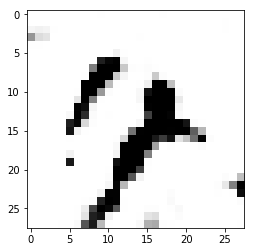

Estimate: [[-0.66571897]]
Iteration: 12600 at 2018-02-23 17:43:30.469870


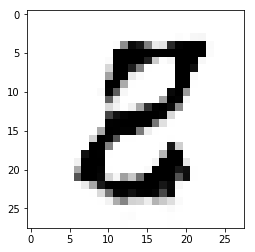

Estimate: [[-0.26916271]]
Iteration: 12700 at 2018-02-23 17:43:41.978887


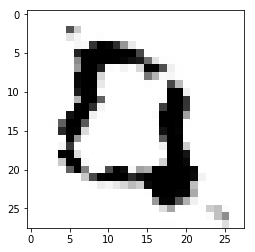

Estimate: [[ 0.63684767]]
Iteration: 12800 at 2018-02-23 17:43:53.503084


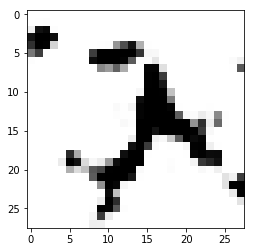

Estimate: [[-1.00514352]]
Iteration: 12900 at 2018-02-23 17:44:05.103396


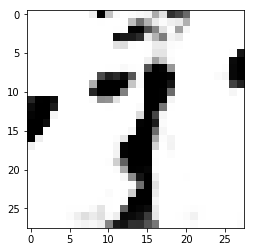

Estimate: [[-1.02576447]]
Iteration: 13000 at 2018-02-23 17:44:16.850913


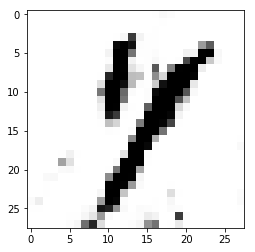

Estimate: [[ 0.46357644]]
Iteration: 13100 at 2018-02-23 17:44:28.369753


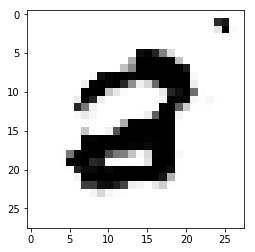

Estimate: [[-0.19428556]]
Iteration: 13200 at 2018-02-23 17:44:39.834449


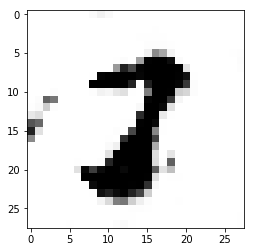

Estimate: [[-1.14970458]]
Iteration: 13300 at 2018-02-23 17:44:51.600592


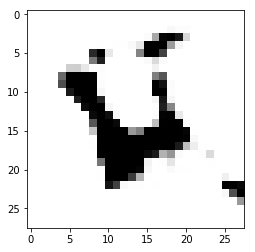

Estimate: [[-1.45351171]]
Iteration: 13400 at 2018-02-23 17:45:03.145293


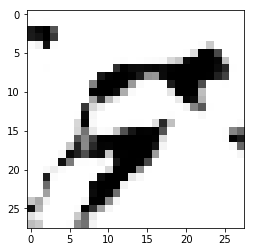

Estimate: [[ 1.43675637]]
Iteration: 13500 at 2018-02-23 17:45:14.772342


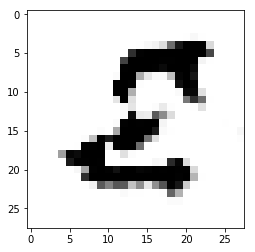

Estimate: [[-0.44083935]]
Iteration: 13600 at 2018-02-23 17:45:26.281749


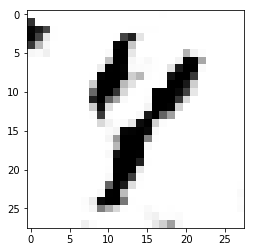

Estimate: [[-0.45990223]]
Iteration: 13700 at 2018-02-23 17:45:37.931974


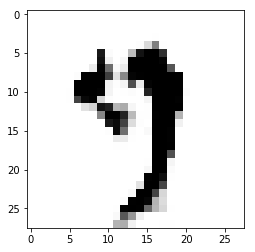

Estimate: [[-0.58278239]]
Iteration: 13800 at 2018-02-23 17:45:49.571830


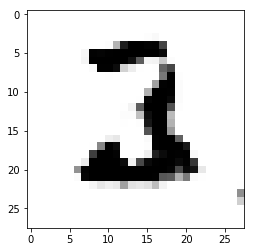

Estimate: [[ 0.07128081]]
Iteration: 13900 at 2018-02-23 17:46:01.263231


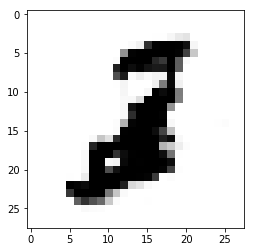

Estimate: [[-1.00777817]]
Iteration: 14000 at 2018-02-23 17:46:12.880395


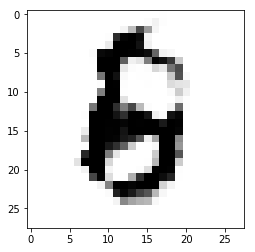

Estimate: [[ 0.31467962]]
Iteration: 14100 at 2018-02-23 17:46:24.566393


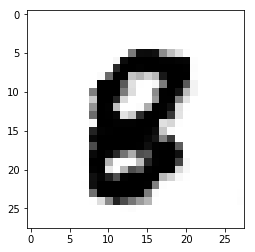

Estimate: [[ 0.66991723]]
Iteration: 14200 at 2018-02-23 17:46:36.129119


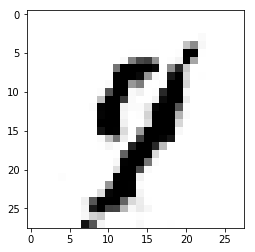

Estimate: [[ 0.44609004]]
Iteration: 14300 at 2018-02-23 17:46:47.717131


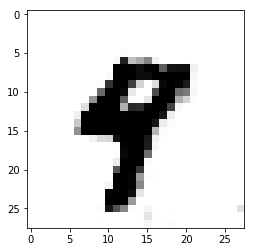

Estimate: [[ 0.3765392]]
Iteration: 14400 at 2018-02-23 17:46:59.191570


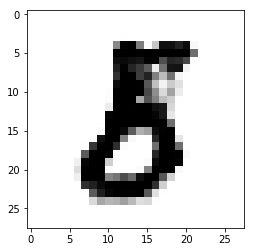

Estimate: [[ 1.27580178]]
Iteration: 14500 at 2018-02-23 17:47:10.727282


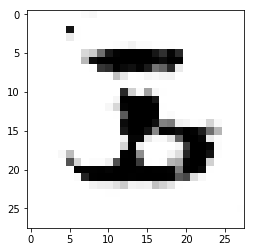

Estimate: [[ 0.97662145]]
Iteration: 14600 at 2018-02-23 17:47:22.570082


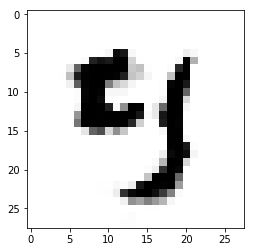

Estimate: [[-1.33183408]]
Iteration: 14700 at 2018-02-23 17:47:34.176781


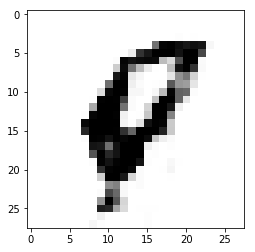

Estimate: [[-0.77213609]]
Iteration: 14800 at 2018-02-23 17:47:45.929903


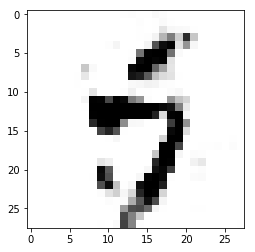

Estimate: [[-1.09832549]]
Iteration: 14900 at 2018-02-23 17:47:57.643070


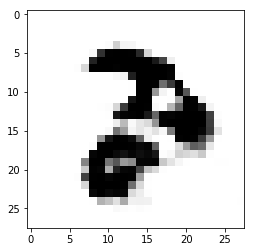

Estimate: [[ 0.05028214]]
Iteration: 15000 at 2018-02-23 17:48:09.310021


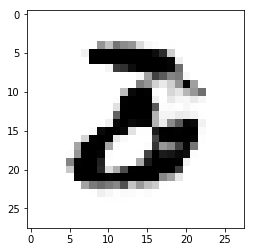

Estimate: [[ 0.52469069]]
Iteration: 15100 at 2018-02-23 17:48:21.182416


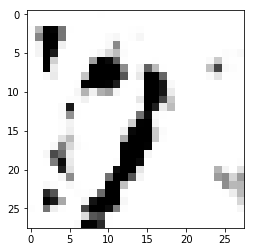

Estimate: [[-2.12685108]]
Iteration: 15200 at 2018-02-23 17:48:32.964283


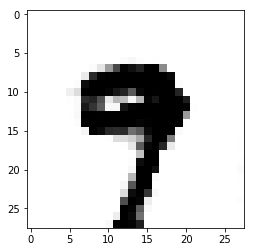

Estimate: [[-0.51915139]]
Iteration: 15300 at 2018-02-23 17:48:44.573511


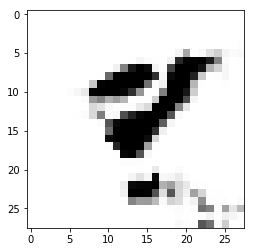

Estimate: [[-2.00768256]]
Iteration: 15400 at 2018-02-23 17:48:56.175572


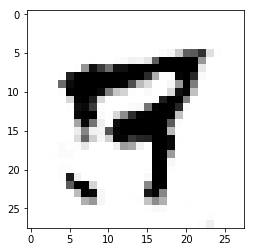

Estimate: [[-1.29351282]]
Iteration: 15500 at 2018-02-23 17:49:08.086270


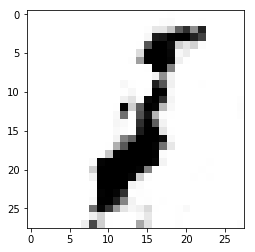

Estimate: [[-1.69597208]]
Iteration: 15600 at 2018-02-23 17:49:19.923412


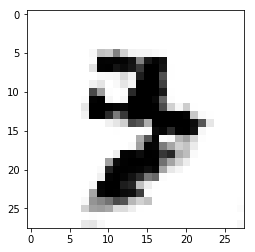

Estimate: [[-0.14503877]]
Iteration: 15700 at 2018-02-23 17:49:31.649438


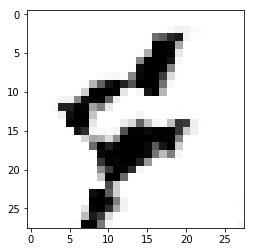

Estimate: [[-0.34975377]]
Iteration: 15800 at 2018-02-23 17:49:43.838894


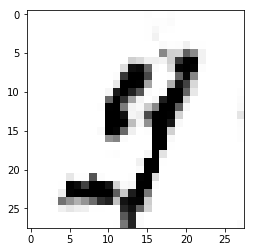

Estimate: [[-0.42556068]]
Iteration: 15900 at 2018-02-23 17:49:55.601714


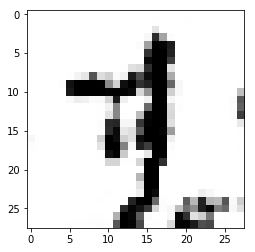

Estimate: [[-2.08203125]]
Iteration: 16000 at 2018-02-23 17:50:07.240587


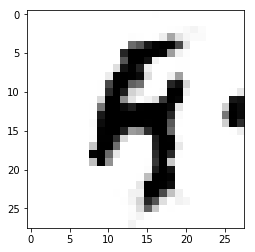

Estimate: [[ 0.34167057]]
Iteration: 16100 at 2018-02-23 17:50:19.086243


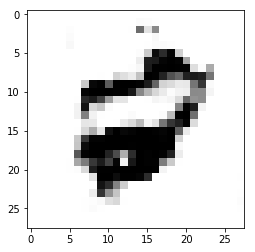

Estimate: [[-0.55264103]]
Iteration: 16200 at 2018-02-23 17:50:30.945894


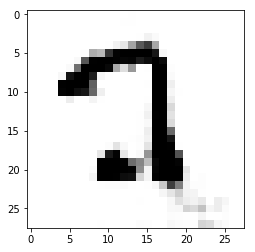

Estimate: [[ 1.36414182]]
Iteration: 16300 at 2018-02-23 17:50:42.630608


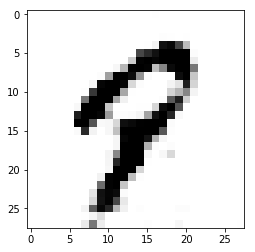

Estimate: [[ 0.92173684]]
Iteration: 16400 at 2018-02-23 17:50:54.503272


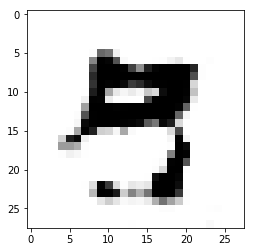

Estimate: [[-1.08133614]]
Iteration: 16500 at 2018-02-23 17:51:06.336912


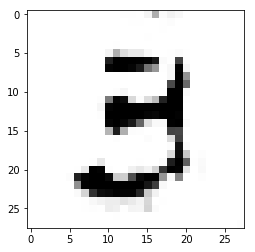

Estimate: [[ 0.30740556]]
Iteration: 16600 at 2018-02-23 17:51:18.275600


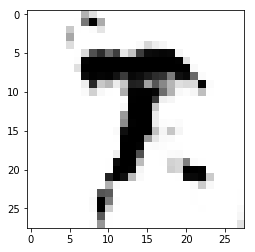

Estimate: [[-0.01992553]]
Iteration: 16700 at 2018-02-23 17:51:29.946295


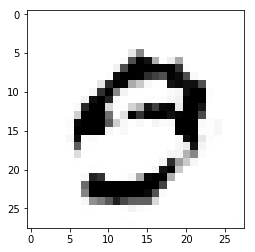

Estimate: [[-0.45963103]]
Iteration: 16800 at 2018-02-23 17:51:41.732679


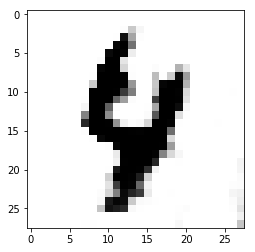

Estimate: [[ 0.08689068]]
Iteration: 16900 at 2018-02-23 17:51:53.785774


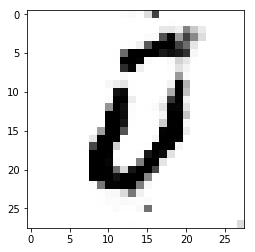

Estimate: [[-0.46590209]]
Iteration: 17000 at 2018-02-23 17:52:05.385344


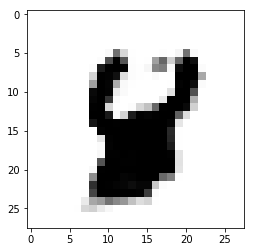

Estimate: [[ 0.72443736]]
Iteration: 17100 at 2018-02-23 17:52:17.032356


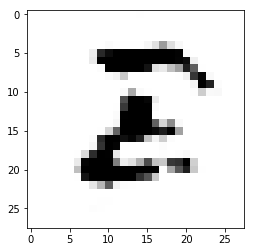

Estimate: [[-0.54748237]]
Iteration: 17200 at 2018-02-23 17:52:28.821574


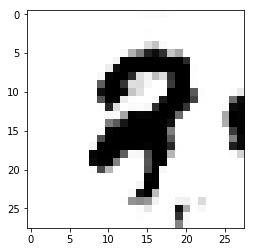

Estimate: [[-1.1663208]]
Iteration: 17300 at 2018-02-23 17:52:40.694359


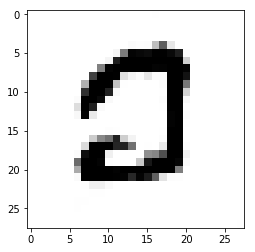

Estimate: [[ 0.04698123]]
Iteration: 17400 at 2018-02-23 17:52:52.435061


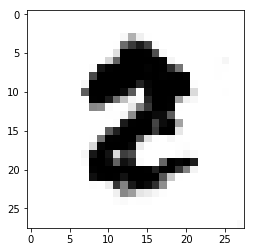

Estimate: [[ 0.20388097]]
Iteration: 17500 at 2018-02-23 17:53:04.493892


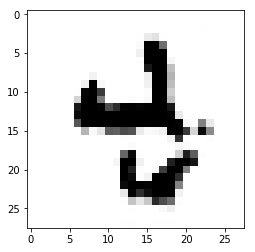

Estimate: [[ 1.04215503]]
Iteration: 17600 at 2018-02-23 17:53:16.436509


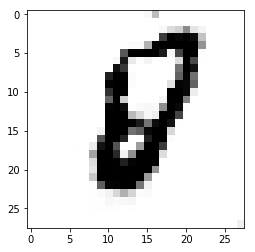

Estimate: [[ 1.00029767]]
Iteration: 17700 at 2018-02-23 17:53:28.273470


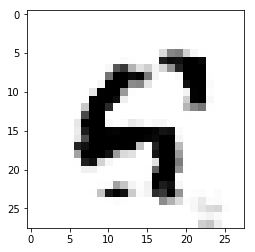

Estimate: [[-0.86715704]]
Iteration: 17800 at 2018-02-23 17:53:40.051053


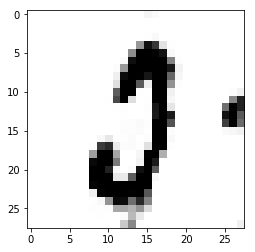

Estimate: [[ 0.15106419]]
Iteration: 17900 at 2018-02-23 17:53:51.931889


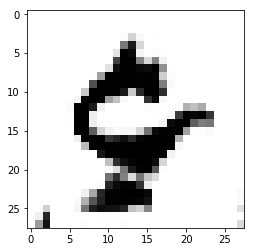

Estimate: [[ 0.36897197]]
Iteration: 18000 at 2018-02-23 17:54:03.856604


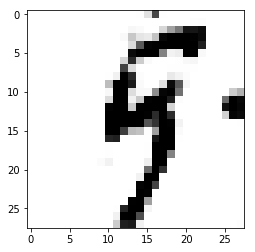

Estimate: [[ 0.47169828]]
Iteration: 18100 at 2018-02-23 17:54:15.643767


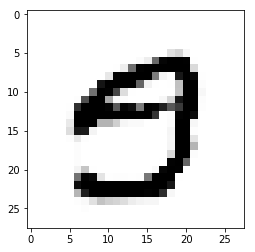

Estimate: [[ 0.82368076]]
Iteration: 18200 at 2018-02-23 17:54:27.419301


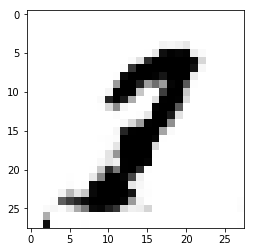

Estimate: [[-0.8414526]]
Iteration: 18300 at 2018-02-23 17:54:39.141872


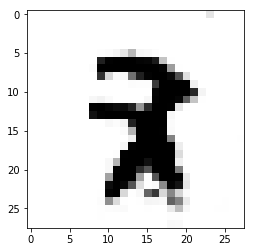

Estimate: [[-1.06089425]]
Iteration: 18400 at 2018-02-23 17:54:51.050408


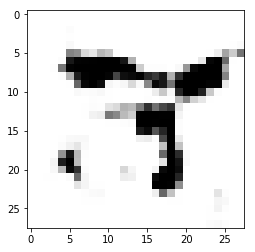

Estimate: [[-0.57447439]]
Iteration: 18500 at 2018-02-23 17:55:02.769338


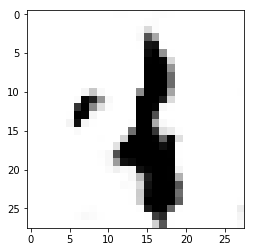

Estimate: [[ 0.27873528]]
Iteration: 18600 at 2018-02-23 17:55:14.384576


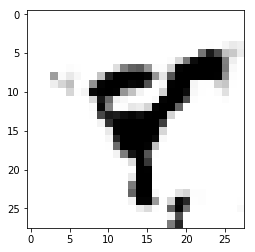

Estimate: [[-0.00440688]]
Iteration: 18700 at 2018-02-23 17:55:26.019425


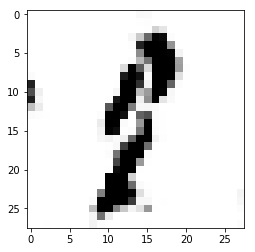

Estimate: [[ 0.05772682]]
Iteration: 18800 at 2018-02-23 17:55:37.662771


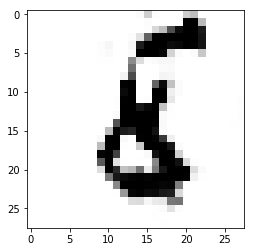

Estimate: [[ 0.37782693]]
Iteration: 18900 at 2018-02-23 17:55:49.331458


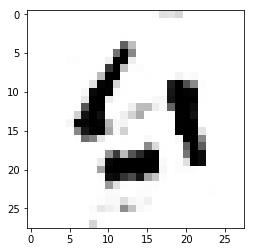

Estimate: [[ 0.17190968]]
Iteration: 19000 at 2018-02-23 17:56:00.956936


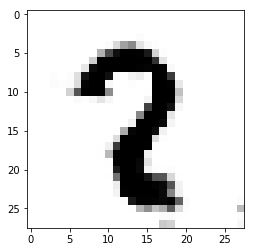

Estimate: [[ 0.5068627]]
Iteration: 19100 at 2018-02-23 17:56:12.599553


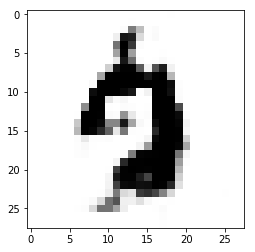

Estimate: [[-0.10871562]]
Iteration: 19200 at 2018-02-23 17:56:24.275127


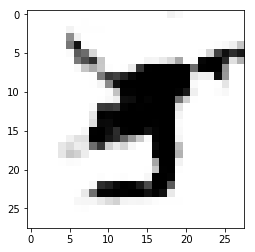

Estimate: [[ 0.97043931]]
Iteration: 19300 at 2018-02-23 17:56:35.916603


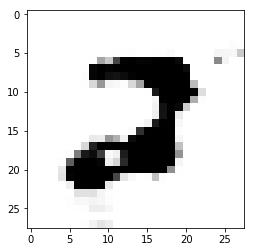

Estimate: [[ 0.99760181]]
Iteration: 19400 at 2018-02-23 17:56:47.730933


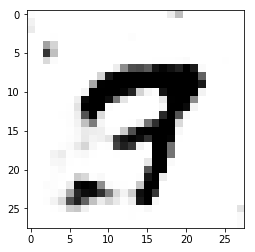

Estimate: [[-0.75243986]]
Iteration: 19500 at 2018-02-23 17:56:59.745850


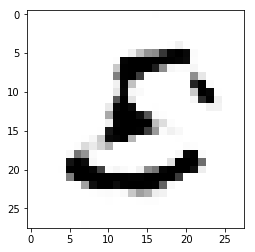

Estimate: [[ 0.19035463]]
Iteration: 19600 at 2018-02-23 17:57:11.523625


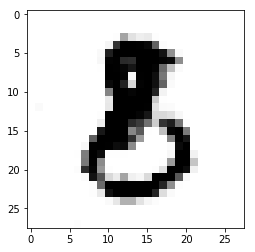

Estimate: [[ 1.12903297]]
Iteration: 19700 at 2018-02-23 17:57:23.931578


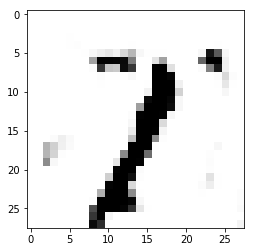

Estimate: [[ 0.56721067]]
Iteration: 19800 at 2018-02-23 17:57:36.117985


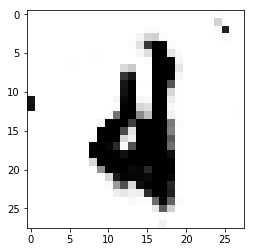

Estimate: [[-0.44310749]]
Iteration: 19900 at 2018-02-23 17:57:48.250999


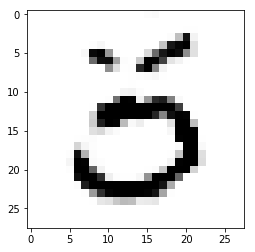

Estimate: [[ 1.04184628]]
Iteration: 20000 at 2018-02-23 17:58:00.185658


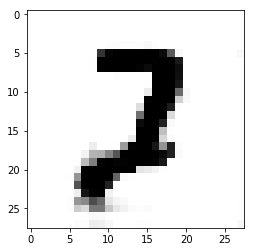

Estimate: [[ 0.55690241]]
Iteration: 20100 at 2018-02-23 17:58:11.871210


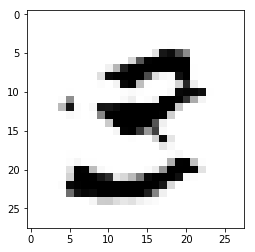

Estimate: [[-0.01307915]]
Iteration: 20200 at 2018-02-23 17:58:23.826104


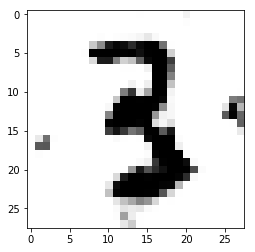

Estimate: [[-0.14190574]]
Iteration: 20300 at 2018-02-23 17:58:35.698857


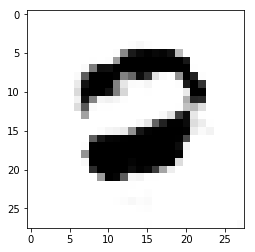

Estimate: [[ 2.06803226]]
Iteration: 20400 at 2018-02-23 17:58:47.673576


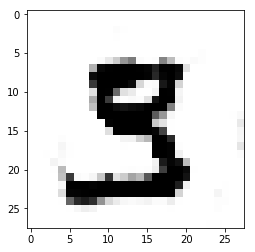

Estimate: [[ 0.28263816]]
Iteration: 20500 at 2018-02-23 17:58:59.820109


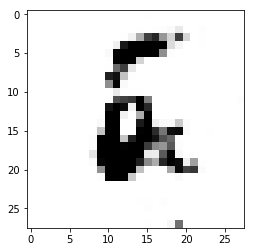

Estimate: [[-0.53922355]]
Iteration: 20600 at 2018-02-23 17:59:12.115052


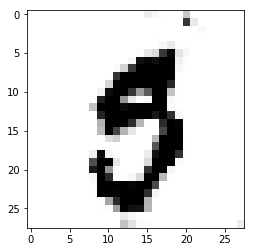

Estimate: [[-0.98788029]]
Iteration: 20700 at 2018-02-23 17:59:24.274656


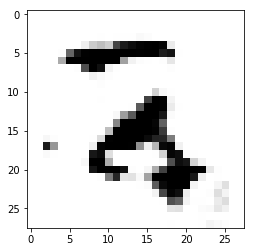

Estimate: [[-0.38365516]]
Iteration: 20800 at 2018-02-23 17:59:36.207361


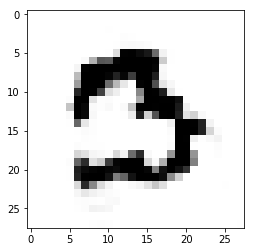

Estimate: [[-1.15736389]]
Iteration: 20900 at 2018-02-23 17:59:48.171164


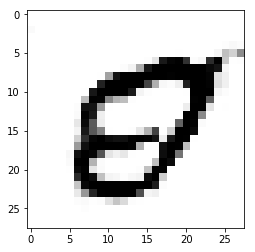

Estimate: [[ 0.38575023]]
Iteration: 21000 at 2018-02-23 18:00:00.126235


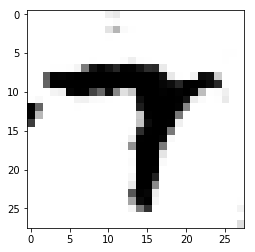

Estimate: [[ 1.10661066]]
Iteration: 21100 at 2018-02-23 18:00:12.204826


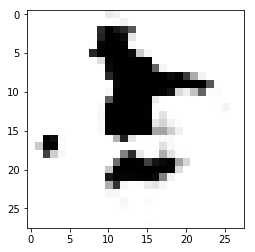

Estimate: [[ 0.03124766]]
Iteration: 21200 at 2018-02-23 18:00:24.206446


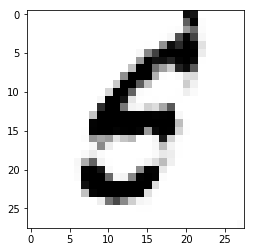

Estimate: [[ 0.30393821]]
Iteration: 21300 at 2018-02-23 18:00:36.173509


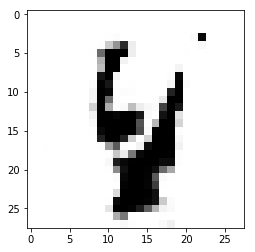

Estimate: [[ 0.05342938]]
Iteration: 21400 at 2018-02-23 18:00:48.163676


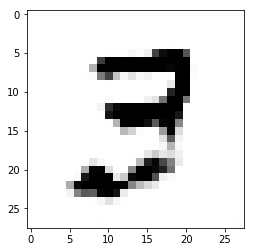

Estimate: [[-0.24089788]]
Iteration: 21500 at 2018-02-23 18:00:59.987618


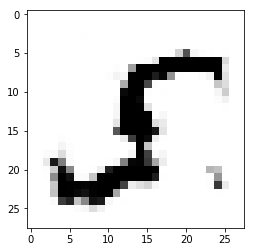

Estimate: [[ 0.57715636]]
Iteration: 21600 at 2018-02-23 18:01:11.759332


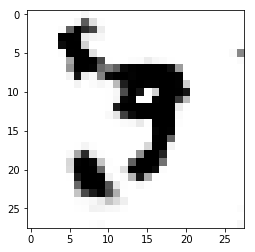

Estimate: [[-0.0576508]]
Iteration: 21700 at 2018-02-23 18:01:23.643455


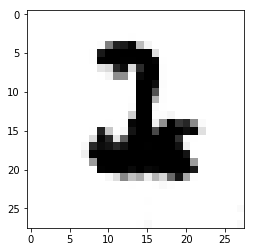

Estimate: [[ 0.15040796]]
Iteration: 21800 at 2018-02-23 18:01:35.453022


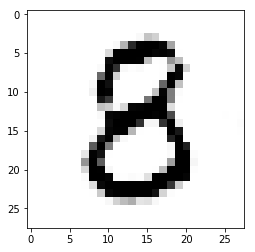

Estimate: [[ 1.03173316]]
Iteration: 21900 at 2018-02-23 18:01:47.324192


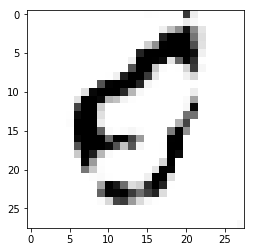

Estimate: [[-1.23241532]]
Iteration: 22000 at 2018-02-23 18:01:59.304728


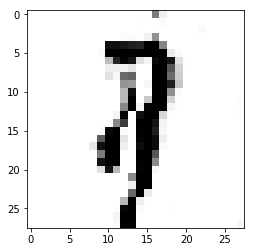

Estimate: [[-0.05500539]]
Iteration: 22100 at 2018-02-23 18:02:11.117467


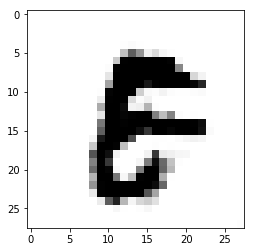

Estimate: [[ 2.07406592]]
Iteration: 22200 at 2018-02-23 18:02:22.937545


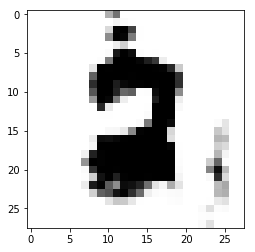

Estimate: [[ 0.34705889]]
Iteration: 22300 at 2018-02-23 18:02:34.812568


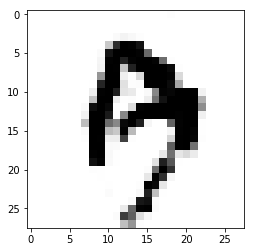

Estimate: [[-3.10181952]]
Iteration: 22400 at 2018-02-23 18:02:46.575071


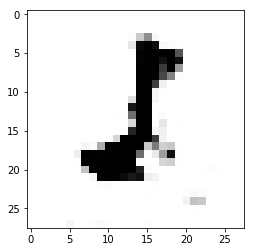

Estimate: [[ 0.47252381]]
Iteration: 22500 at 2018-02-23 18:02:58.610355


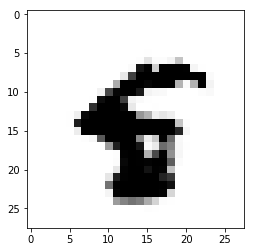

Estimate: [[ 0.27410746]]
Iteration: 22600 at 2018-02-23 18:03:10.672896


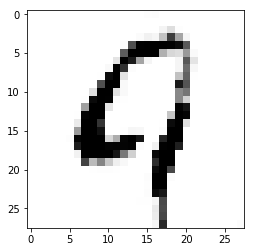

Estimate: [[ 0.27209428]]
Iteration: 22700 at 2018-02-23 18:03:22.612777


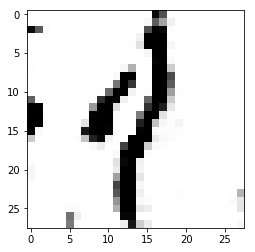

Estimate: [[-2.00725508]]
Iteration: 22800 at 2018-02-23 18:03:34.861952


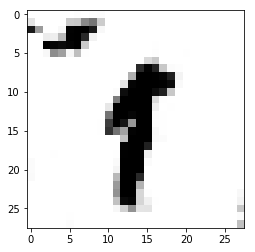

Estimate: [[ 1.50164056]]
Iteration: 22900 at 2018-02-23 18:03:46.938950


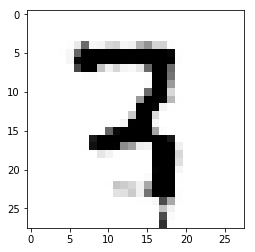

Estimate: [[ 1.45563006]]
Iteration: 23000 at 2018-02-23 18:03:59.117602


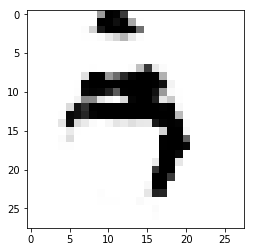

Estimate: [[ 0.30539382]]
Iteration: 23100 at 2018-02-23 18:04:11.246279


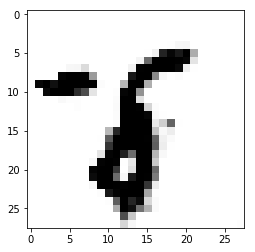

Estimate: [[ 1.63513243]]
Iteration: 23200 at 2018-02-23 18:04:23.223201


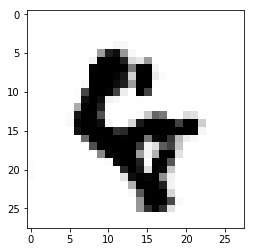

Estimate: [[ 0.20667741]]
Iteration: 23300 at 2018-02-23 18:04:35.086571


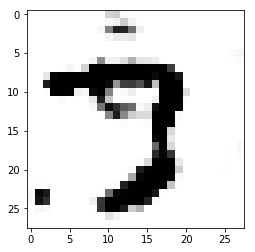

Estimate: [[-0.08929202]]
Iteration: 23400 at 2018-02-23 18:04:46.900879


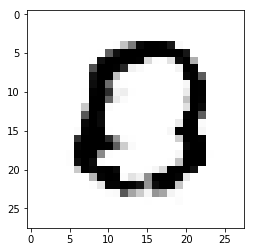

Estimate: [[ 3.93930578]]
Iteration: 23500 at 2018-02-23 18:04:58.823648


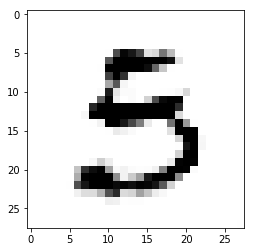

Estimate: [[-0.34140164]]
Iteration: 23600 at 2018-02-23 18:05:11.075390


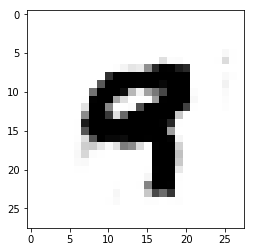

Estimate: [[ 0.9497692]]
Iteration: 23700 at 2018-02-23 18:05:23.171855


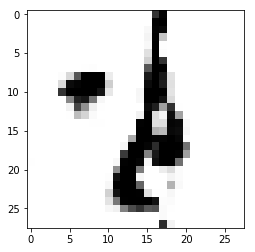

Estimate: [[-0.09525622]]
Iteration: 23800 at 2018-02-23 18:05:35.053687


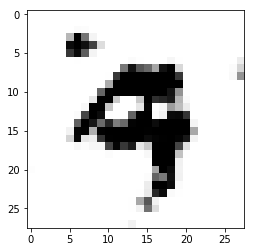

Estimate: [[-0.65717626]]
Iteration: 23900 at 2018-02-23 18:05:47.085088


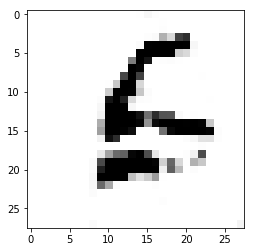

Estimate: [[ 2.59024477]]
Iteration: 24000 at 2018-02-23 18:05:58.975712


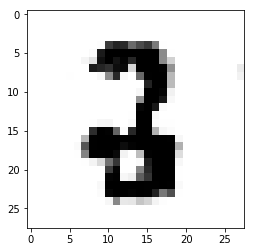

Estimate: [[-0.01592994]]
Iteration: 24100 at 2018-02-23 18:06:10.968754


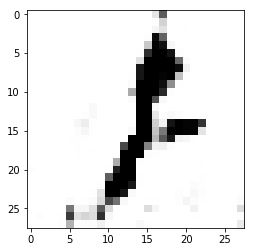

Estimate: [[-0.37573111]]
Iteration: 24200 at 2018-02-23 18:06:23.056937


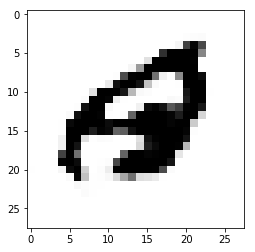

Estimate: [[-1.19830835]]
Iteration: 24300 at 2018-02-23 18:06:35.412360


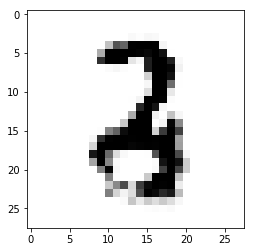

Estimate: [[ 0.47153378]]
Iteration: 24400 at 2018-02-23 18:06:47.545001


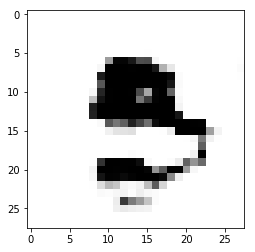

Estimate: [[ 0.67433059]]
Iteration: 24500 at 2018-02-23 18:06:59.434444


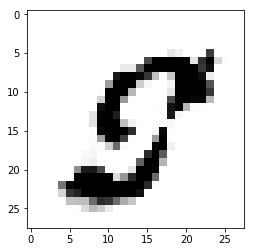

Estimate: [[-1.24649584]]
Iteration: 24600 at 2018-02-23 18:07:11.298324


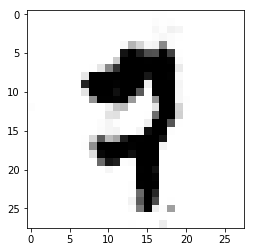

Estimate: [[ 0.15218523]]
Iteration: 24700 at 2018-02-23 18:07:23.551999


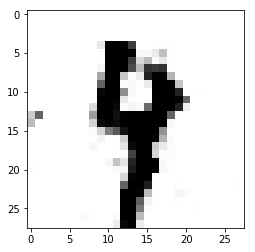

Estimate: [[-2.10581017]]
Iteration: 24800 at 2018-02-23 18:07:35.759239


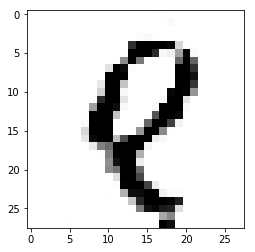

Estimate: [[ 0.24315907]]
Iteration: 24900 at 2018-02-23 18:07:47.754090


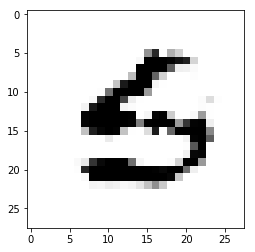

Estimate: [[ 0.1101405]]
Iteration: 25000 at 2018-02-23 18:08:00.164751


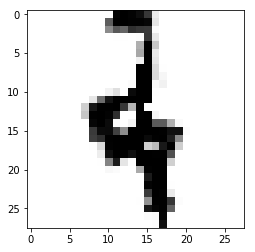

Estimate: [[ 0.46111435]]
Iteration: 25100 at 2018-02-23 18:08:12.182738


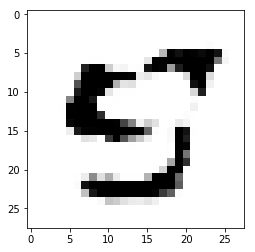

Estimate: [[ 0.51431501]]
Iteration: 25200 at 2018-02-23 18:08:24.112051


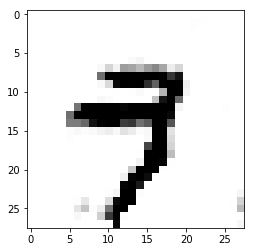

Estimate: [[ 0.76263213]]
Iteration: 25300 at 2018-02-23 18:08:36.492144


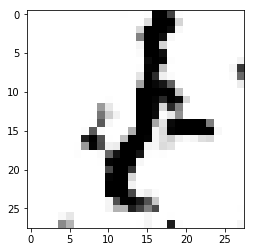

Estimate: [[ 1.66046345]]
Iteration: 25400 at 2018-02-23 18:08:48.546557


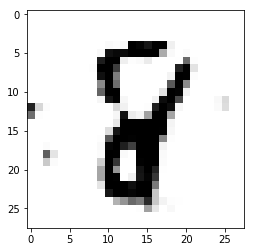

Estimate: [[ 0.19342516]]
Iteration: 25500 at 2018-02-23 18:09:00.630222


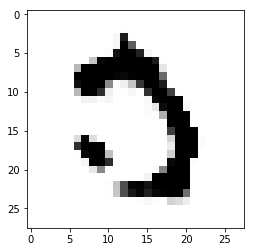

Estimate: [[-0.00971173]]
Iteration: 25600 at 2018-02-23 18:09:12.746504


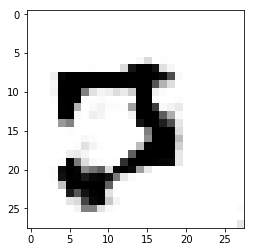

Estimate: [[-0.63804758]]
Iteration: 25700 at 2018-02-23 18:09:24.892503


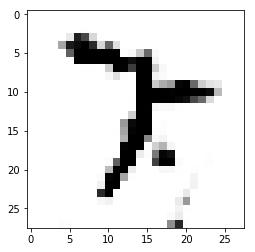

Estimate: [[ 1.54911852]]
Iteration: 25800 at 2018-02-23 18:09:36.887278


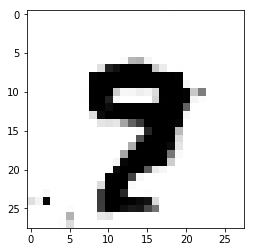

Estimate: [[ 0.83149564]]
Iteration: 25900 at 2018-02-23 18:09:49.099259


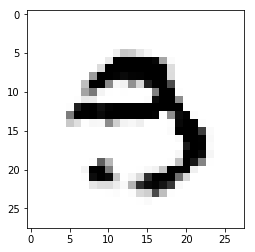

Estimate: [[ 1.04621315]]
Iteration: 26000 at 2018-02-23 18:10:01.137874


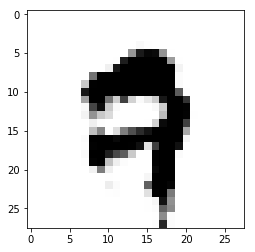

Estimate: [[-1.37057555]]
Iteration: 26100 at 2018-02-23 18:10:13.296402


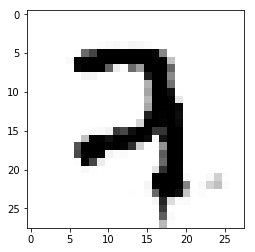

Estimate: [[ 0.39878136]]
Iteration: 26200 at 2018-02-23 18:10:25.397110


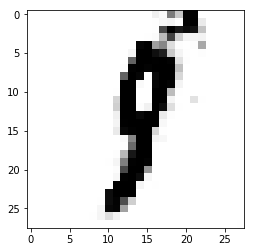

Estimate: [[ 2.50726509]]
Iteration: 26300 at 2018-02-23 18:10:37.555540


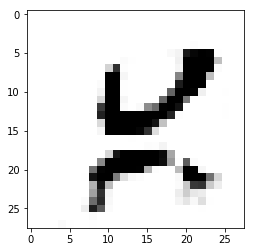

Estimate: [[ 2.56135821]]
Iteration: 26400 at 2018-02-23 18:10:49.630675


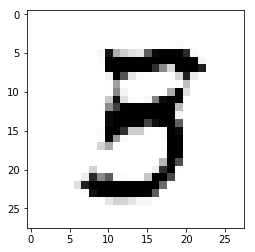

Estimate: [[ 0.43021286]]
Iteration: 26500 at 2018-02-23 18:11:01.871930


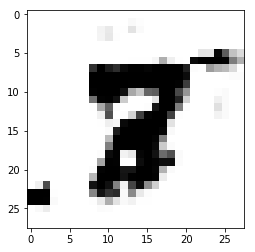

Estimate: [[-1.09796834]]
Iteration: 26600 at 2018-02-23 18:11:13.902345


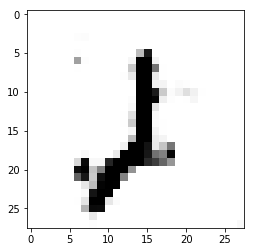

Estimate: [[ 0.56810355]]
Iteration: 26700 at 2018-02-23 18:11:25.957669


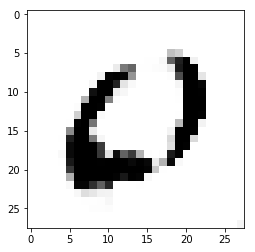

Estimate: [[ 1.72913265]]
Iteration: 26800 at 2018-02-23 18:11:38.050353


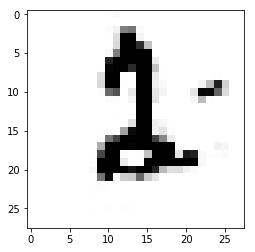

Estimate: [[ 0.87459302]]
Iteration: 26900 at 2018-02-23 18:11:50.149916


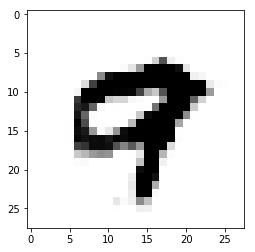

Estimate: [[ 1.49328911]]
Iteration: 27000 at 2018-02-23 18:12:02.230039


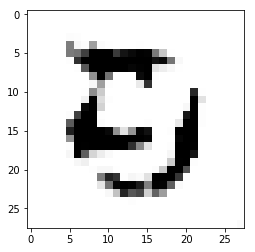

Estimate: [[-1.62586999]]
Iteration: 27100 at 2018-02-23 18:12:14.175027


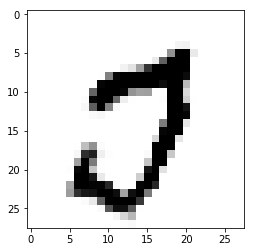

Estimate: [[-0.03620356]]
Iteration: 27200 at 2018-02-23 18:12:26.350655


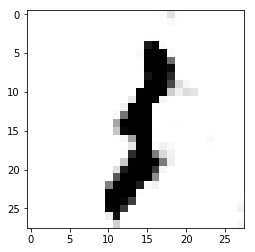

Estimate: [[-0.68003488]]
Iteration: 27300 at 2018-02-23 18:12:38.739738


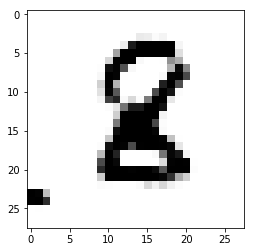

Estimate: [[ 0.07123595]]
Iteration: 27400 at 2018-02-23 18:12:50.778610


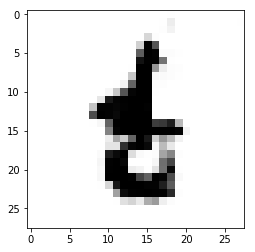

Estimate: [[ 0.96243685]]
Iteration: 27500 at 2018-02-23 18:13:03.127346


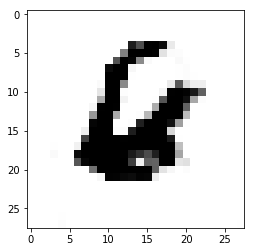

Estimate: [[ 0.75507534]]
Iteration: 27600 at 2018-02-23 18:13:15.491899


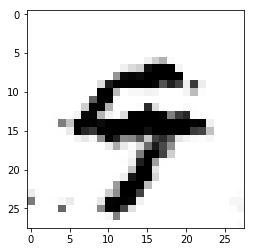

Estimate: [[ 0.29982853]]
Iteration: 27700 at 2018-02-23 18:13:27.576798


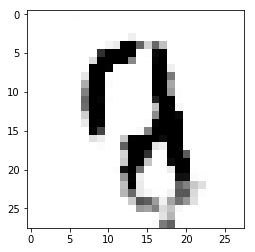

Estimate: [[ 2.92059898]]
Iteration: 27800 at 2018-02-23 18:13:39.602945


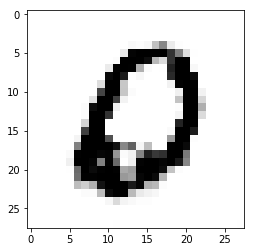

Estimate: [[ 1.37366414]]
Iteration: 27900 at 2018-02-23 18:13:51.939406


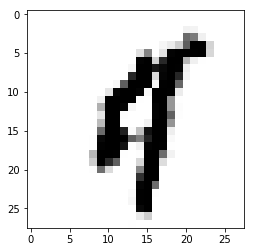

Estimate: [[ 0.39565638]]
Iteration: 28000 at 2018-02-23 18:14:03.966737


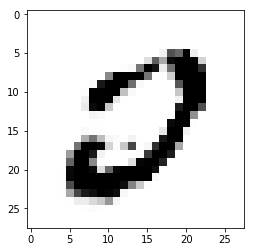

Estimate: [[ 0.13339174]]
Iteration: 28100 at 2018-02-23 18:14:16.172317


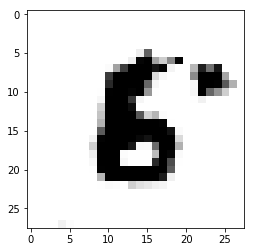

Estimate: [[-0.6980015]]
Iteration: 28200 at 2018-02-23 18:14:28.468527


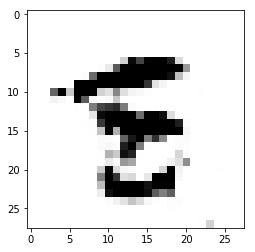

Estimate: [[-0.58896148]]
Iteration: 28300 at 2018-02-23 18:14:40.752101


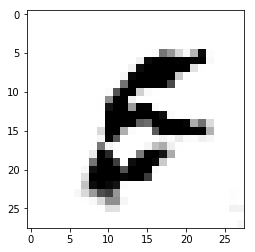

Estimate: [[ 0.19454519]]
Iteration: 28400 at 2018-02-23 18:14:52.894173


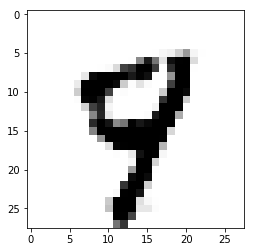

Estimate: [[-0.22096457]]
Iteration: 28500 at 2018-02-23 18:15:04.883153


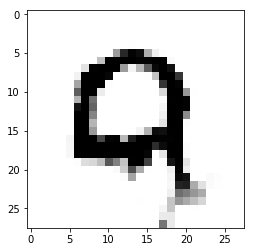

Estimate: [[ 4.58459759]]
Iteration: 28600 at 2018-02-23 18:15:17.074301


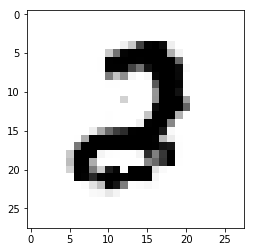

Estimate: [[ 1.37898278]]
Iteration: 28700 at 2018-02-23 18:15:29.215628


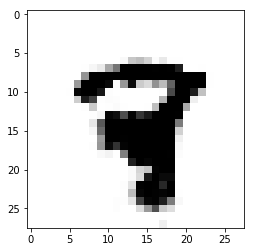

Estimate: [[ 0.48836359]]
Iteration: 28800 at 2018-02-23 18:15:41.591814


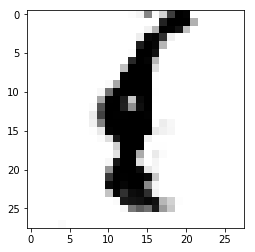

Estimate: [[ 0.01177633]]
Iteration: 28900 at 2018-02-23 18:15:53.736590


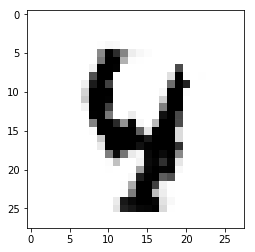

Estimate: [[ 1.36769176]]
Iteration: 29000 at 2018-02-23 18:16:05.984534


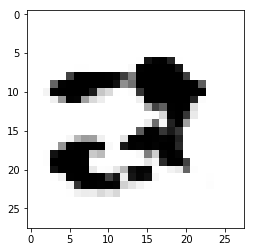

Estimate: [[-0.18345904]]
Iteration: 29100 at 2018-02-23 18:16:18.444232


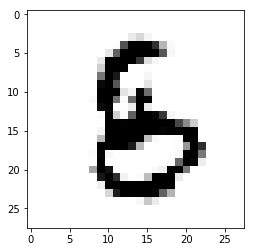

Estimate: [[-0.10599411]]
Iteration: 29200 at 2018-02-23 18:16:30.757700


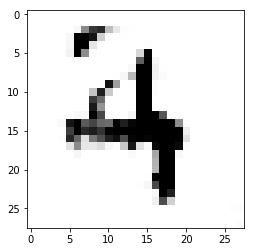

Estimate: [[ 0.44255537]]
Iteration: 29300 at 2018-02-23 18:16:42.789896


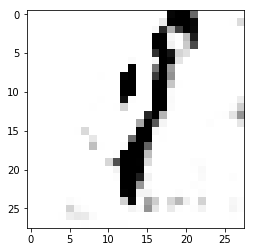

Estimate: [[ 2.46651363]]
Iteration: 29400 at 2018-02-23 18:16:55.158139


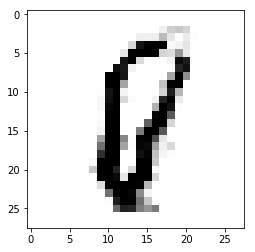

Estimate: [[ 0.6737932]]
Iteration: 29500 at 2018-02-23 18:17:07.401941


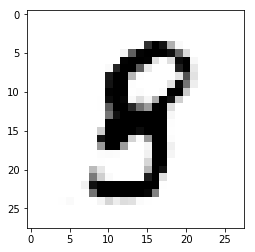

Estimate: [[-0.69351208]]
Iteration: 29600 at 2018-02-23 18:17:19.614746


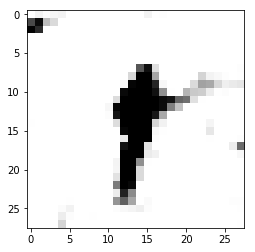

Estimate: [[ 0.84503841]]
Iteration: 29700 at 2018-02-23 18:17:32.284574


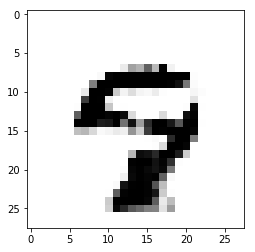

Estimate: [[-0.71496361]]
Iteration: 29800 at 2018-02-23 18:17:44.438570


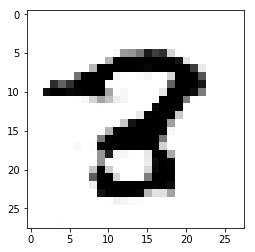

Estimate: [[ 0.7492525]]
Iteration: 29900 at 2018-02-23 18:17:56.649262


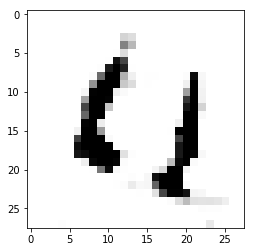

Estimate: [[ 2.86612988]]
Iteration: 30000 at 2018-02-23 18:18:08.707376


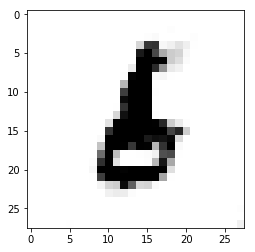

Estimate: [[ 0.99274307]]
Iteration: 30100 at 2018-02-23 18:18:20.777777


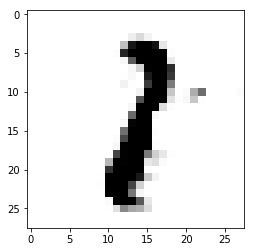

Estimate: [[ 0.09364329]]
Iteration: 30200 at 2018-02-23 18:18:32.875867


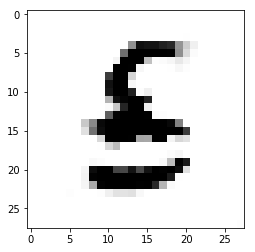

Estimate: [[ 0.84686756]]
Iteration: 30300 at 2018-02-23 18:18:45.235683


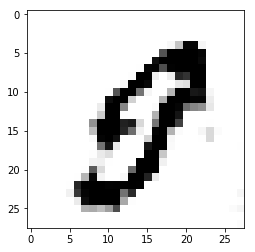

Estimate: [[ 1.35412097]]
Iteration: 30400 at 2018-02-23 18:18:57.318983


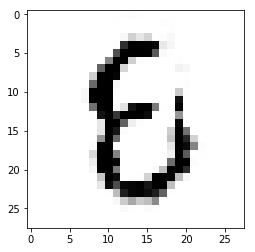

Estimate: [[ 0.1419141]]
Iteration: 30500 at 2018-02-23 18:19:09.897232


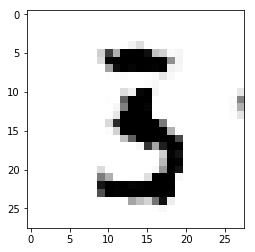

Estimate: [[ 0.8099882]]
Iteration: 30600 at 2018-02-23 18:19:22.016537


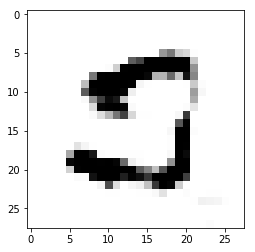

Estimate: [[-1.80260265]]
Iteration: 30700 at 2018-02-23 18:19:34.209841


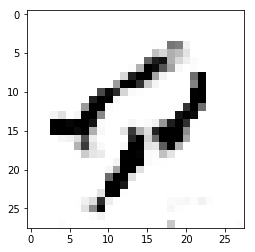

Estimate: [[-0.37935001]]
Iteration: 30800 at 2018-02-23 18:19:46.512200


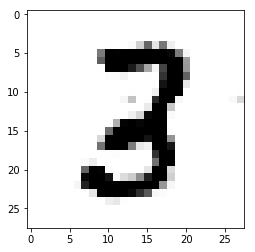

Estimate: [[ 1.51746643]]
Iteration: 30900 at 2018-02-23 18:19:59.015157


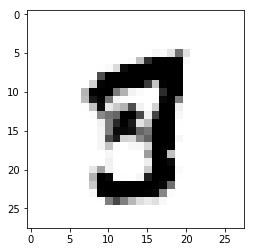

Estimate: [[-0.70140469]]
Iteration: 31000 at 2018-02-23 18:20:11.411295


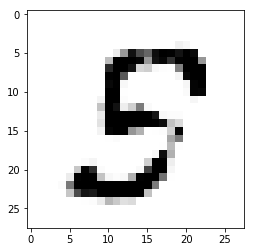

Estimate: [[ 0.72625792]]
Iteration: 31100 at 2018-02-23 18:20:23.744892


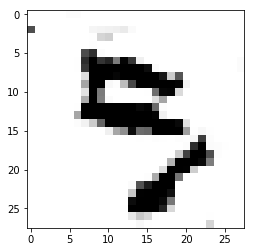

Estimate: [[ 0.36147386]]
Iteration: 31200 at 2018-02-23 18:20:36.175798


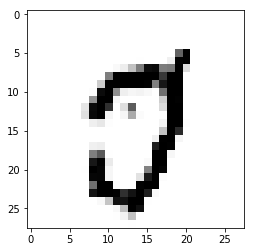

Estimate: [[-0.73779911]]
Iteration: 31300 at 2018-02-23 18:20:48.382973


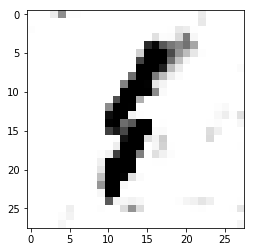

Estimate: [[ 0.14988264]]
Iteration: 31400 at 2018-02-23 18:21:00.687218


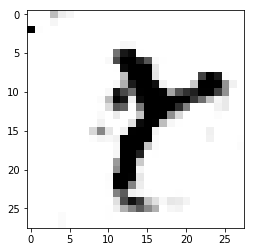

Estimate: [[ 0.55784059]]
Iteration: 31500 at 2018-02-23 18:21:13.034314


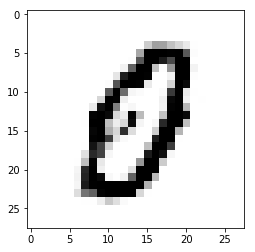

Estimate: [[-0.35996407]]
Iteration: 31600 at 2018-02-23 18:21:25.567685


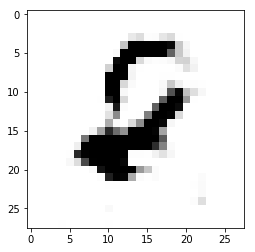

Estimate: [[-1.08830738]]
Iteration: 31700 at 2018-02-23 18:21:38.055649


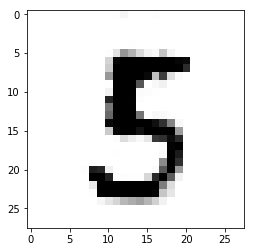

Estimate: [[ 0.7741161]]
Iteration: 31800 at 2018-02-23 18:21:50.449126


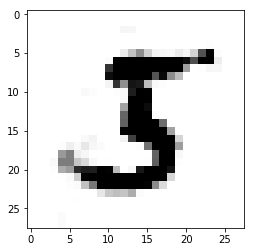

Estimate: [[ 0.56265777]]
Iteration: 31900 at 2018-02-23 18:22:02.825864


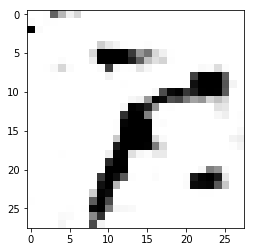

Estimate: [[ 0.58666843]]
Iteration: 32000 at 2018-02-23 18:22:15.065372


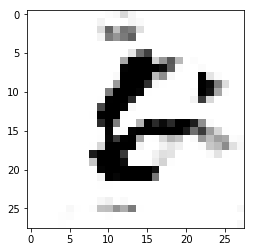

Estimate: [[-0.21338923]]
Iteration: 32100 at 2018-02-23 18:22:27.366911


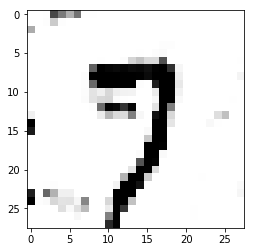

Estimate: [[-1.42173457]]
Iteration: 32200 at 2018-02-23 18:22:39.798608


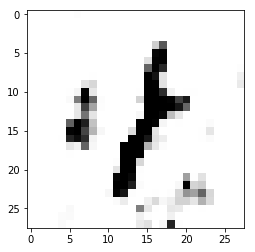

Estimate: [[-0.63066685]]
Iteration: 32300 at 2018-02-23 18:22:52.253291


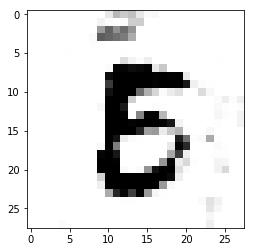

Estimate: [[ 0.13598901]]
Iteration: 32400 at 2018-02-23 18:23:05.171631


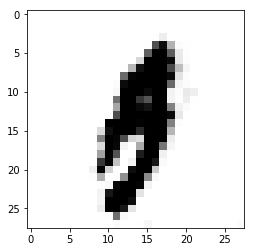

Estimate: [[ 0.29343176]]
Iteration: 32500 at 2018-02-23 18:23:17.823900


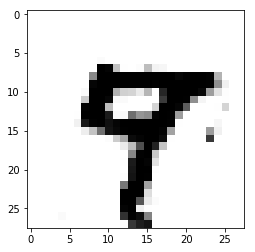

Estimate: [[ 0.51574206]]
Iteration: 32600 at 2018-02-23 18:23:30.357435


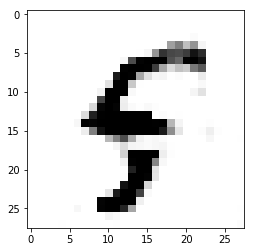

Estimate: [[-0.40952224]]
Iteration: 32700 at 2018-02-23 18:23:42.884317


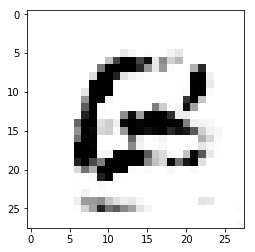

Estimate: [[ 1.43670774]]
Iteration: 32800 at 2018-02-23 18:23:55.479988


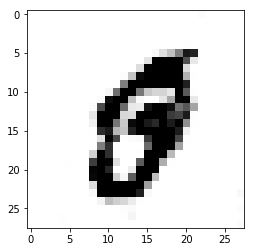

Estimate: [[-0.18075991]]
Iteration: 32900 at 2018-02-23 18:24:07.841444


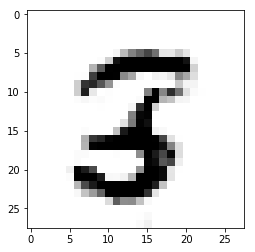

Estimate: [[-0.18578301]]
Iteration: 33000 at 2018-02-23 18:24:20.261656


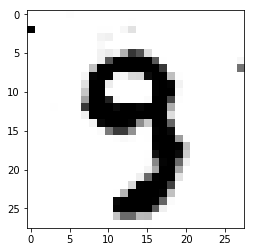

Estimate: [[-0.05312453]]
Iteration: 33100 at 2018-02-23 18:24:32.567590


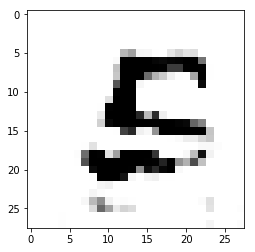

Estimate: [[ 0.57282746]]
Iteration: 33200 at 2018-02-23 18:24:44.951598


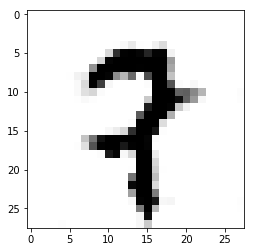

Estimate: [[ 1.3371911]]
Iteration: 33300 at 2018-02-23 18:24:57.351082


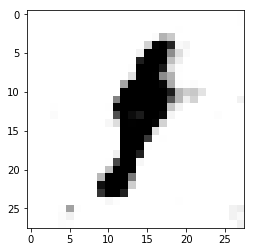

Estimate: [[-0.34146342]]
Iteration: 33400 at 2018-02-23 18:25:09.577330


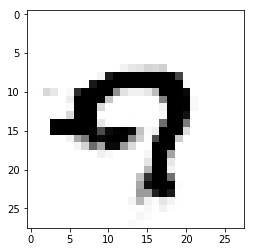

Estimate: [[ 0.0861422]]
Iteration: 33500 at 2018-02-23 18:25:22.049149


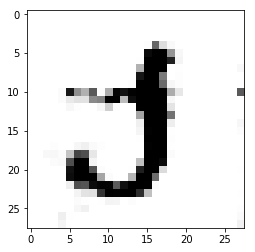

Estimate: [[-0.1381796]]
Iteration: 33600 at 2018-02-23 18:25:34.411969


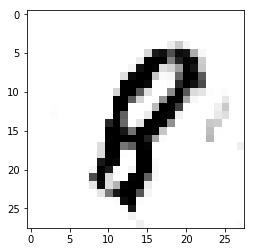

Estimate: [[ 0.09688814]]
Iteration: 33700 at 2018-02-23 18:25:47.032129


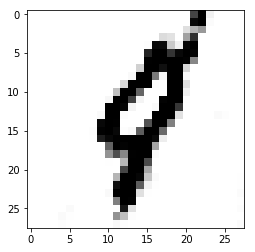

Estimate: [[-1.62432194]]
Iteration: 33800 at 2018-02-23 18:25:59.498948


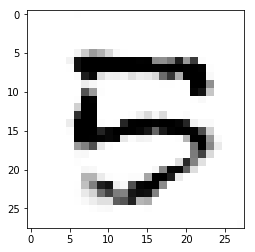

Estimate: [[ 3.02828765]]
Iteration: 33900 at 2018-02-23 18:26:11.845628


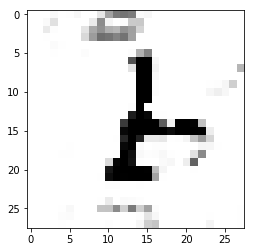

Estimate: [[-0.10535319]]
Iteration: 34000 at 2018-02-23 18:26:24.221684


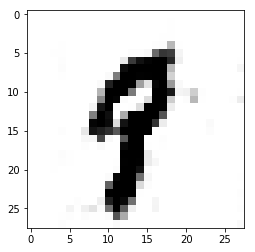

Estimate: [[-1.2536006]]
Iteration: 34100 at 2018-02-23 18:26:36.846272


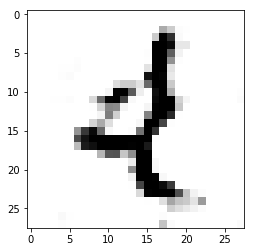

Estimate: [[ 1.22200966]]
Iteration: 34200 at 2018-02-23 18:26:49.211968


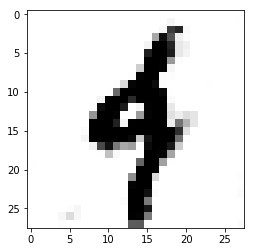

Estimate: [[-0.00796258]]
Iteration: 34300 at 2018-02-23 18:27:01.572015


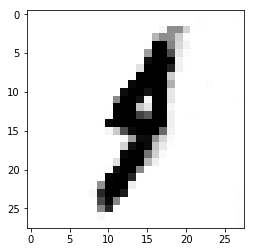

Estimate: [[-0.39714772]]
Iteration: 34400 at 2018-02-23 18:27:13.945875


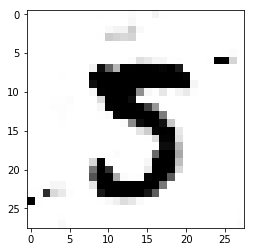

Estimate: [[ 0.26392728]]
Iteration: 34500 at 2018-02-23 18:27:26.557212


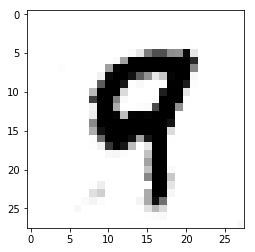

Estimate: [[-0.68728638]]
Iteration: 34600 at 2018-02-23 18:27:38.907927


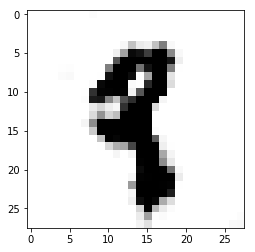

Estimate: [[-1.85521066]]
Iteration: 34700 at 2018-02-23 18:27:51.449232


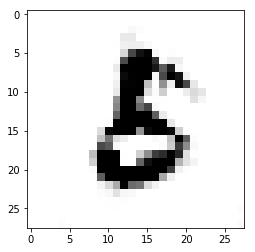

Estimate: [[-1.47401166]]
Iteration: 34800 at 2018-02-23 18:28:03.977190


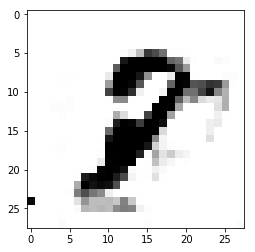

Estimate: [[-0.60837024]]
Iteration: 34900 at 2018-02-23 18:28:16.501453


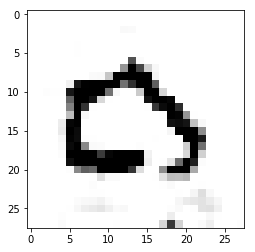

Estimate: [[ 1.3222928]]
Iteration: 35000 at 2018-02-23 18:28:29.079858


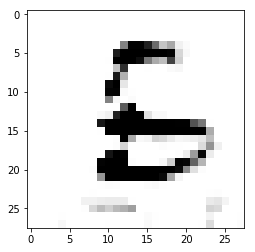

Estimate: [[ 0.09619099]]
Iteration: 35100 at 2018-02-23 18:28:41.660358


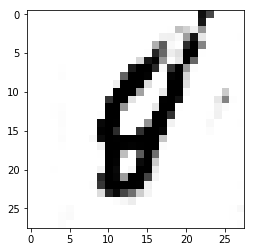

Estimate: [[-0.39347941]]
Iteration: 35200 at 2018-02-23 18:28:54.211827


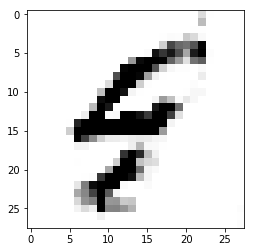

Estimate: [[ 3.03159022]]
Iteration: 35300 at 2018-02-23 18:29:07.183555


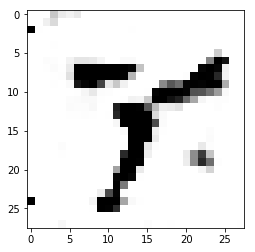

Estimate: [[ 2.0308497]]
Iteration: 35400 at 2018-02-23 18:29:19.484450


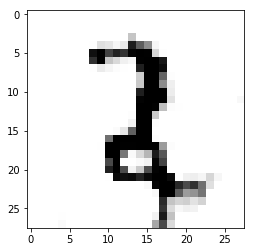

Estimate: [[ 1.11056447]]
Iteration: 35500 at 2018-02-23 18:29:32.042135


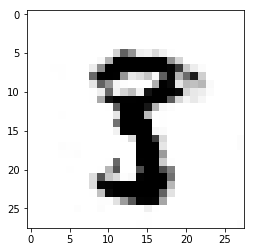

Estimate: [[-0.57449132]]
Iteration: 35600 at 2018-02-23 18:29:44.577986


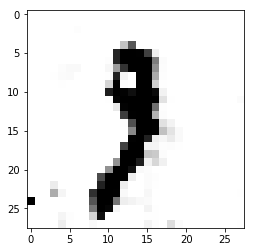

Estimate: [[-0.04733036]]
Iteration: 35700 at 2018-02-23 18:29:56.947318


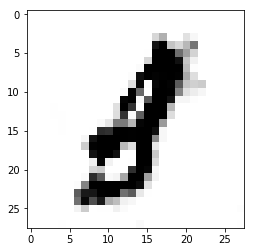

Estimate: [[-0.26352224]]
Iteration: 35800 at 2018-02-23 18:30:09.571574


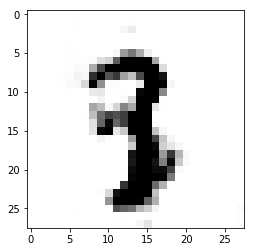

Estimate: [[-0.40559614]]
Iteration: 35900 at 2018-02-23 18:30:22.052751


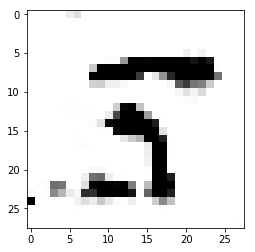

Estimate: [[ 1.80438924]]
Iteration: 36000 at 2018-02-23 18:30:34.580802


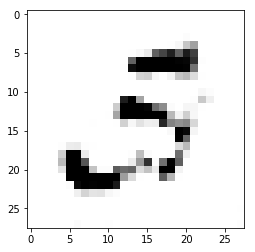

Estimate: [[-2.73327541]]
Iteration: 36100 at 2018-02-23 18:30:46.989606


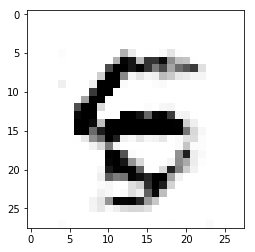

Estimate: [[-0.16170664]]
Iteration: 36200 at 2018-02-23 18:31:00.238948


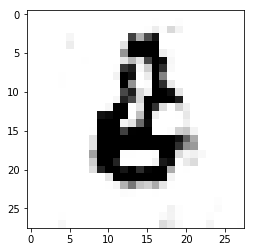

Estimate: [[-1.28913713]]
Iteration: 36300 at 2018-02-23 18:31:12.699505


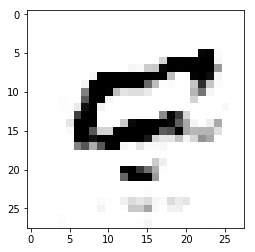

Estimate: [[-1.54559338]]
Iteration: 36400 at 2018-02-23 18:31:25.202306


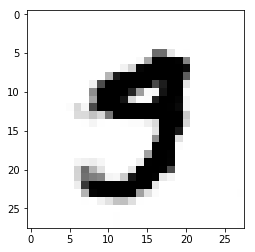

Estimate: [[ 0.29527998]]
Iteration: 36500 at 2018-02-23 18:31:37.757152


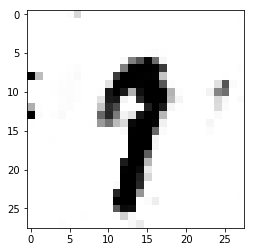

Estimate: [[-1.73660362]]
Iteration: 36600 at 2018-02-23 18:31:50.257467


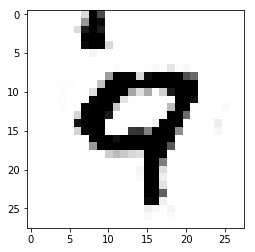

Estimate: [[ 1.26941013]]
Iteration: 36700 at 2018-02-23 18:32:03.080125


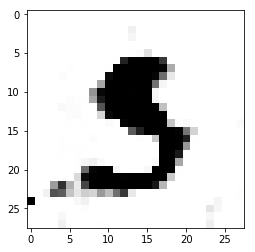

Estimate: [[-0.74718875]]
Iteration: 36800 at 2018-02-23 18:32:15.474689


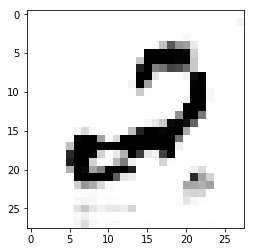

Estimate: [[ 0.38420284]]
Iteration: 36900 at 2018-02-23 18:32:27.938830


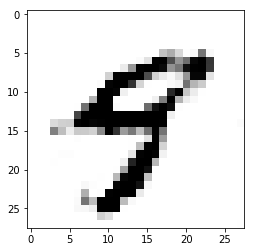

Estimate: [[ 1.19471622]]
Iteration: 37000 at 2018-02-23 18:32:40.417414


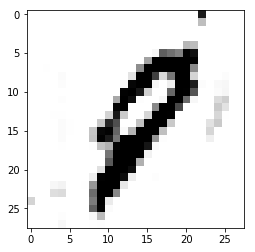

Estimate: [[ 4.99380302]]
Iteration: 37100 at 2018-02-23 18:32:52.971770


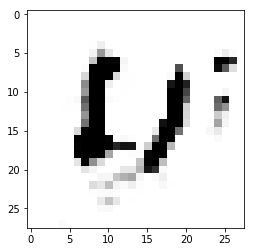

Estimate: [[ 0.7739917]]
Iteration: 37200 at 2018-02-23 18:33:05.334076


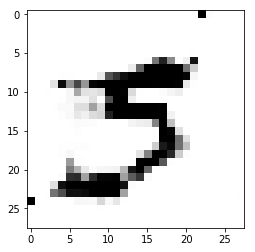

Estimate: [[-1.27878034]]
Iteration: 37300 at 2018-02-23 18:33:17.826324


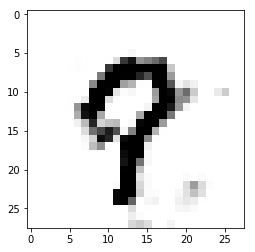

Estimate: [[-1.9186393]]
Iteration: 37400 at 2018-02-23 18:33:30.421501


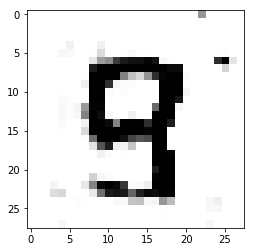

Estimate: [[-2.24169731]]
Iteration: 37500 at 2018-02-23 18:33:42.788672


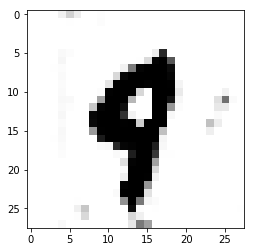

Estimate: [[-1.13054216]]
Iteration: 37600 at 2018-02-23 18:33:55.328052


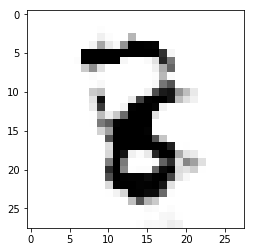

Estimate: [[-1.06431425]]
Iteration: 37700 at 2018-02-23 18:34:08.078966


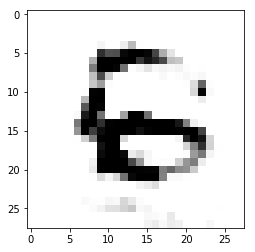

Estimate: [[-2.23690486]]
Iteration: 37800 at 2018-02-23 18:34:20.469532


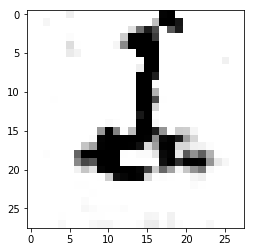

Estimate: [[ 1.2032125]]
Iteration: 37900 at 2018-02-23 18:34:33.093089


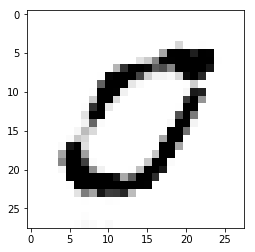

Estimate: [[-1.70263863]]
Iteration: 38000 at 2018-02-23 18:34:45.911947


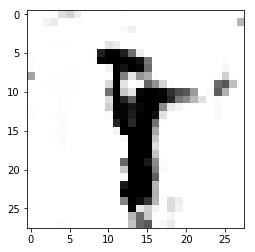

Estimate: [[-1.04861927]]
Iteration: 38100 at 2018-02-23 18:34:58.356433


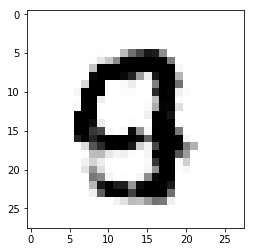

Estimate: [[-0.20758563]]
Iteration: 38200 at 2018-02-23 18:35:11.054353


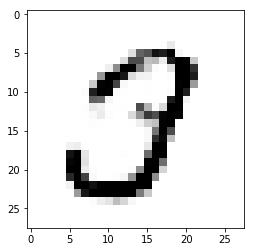

Estimate: [[-0.46543247]]
Iteration: 38300 at 2018-02-23 18:35:23.672318


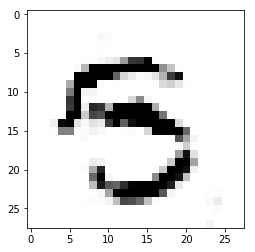

Estimate: [[ 0.07865757]]
Iteration: 38400 at 2018-02-23 18:35:36.198836


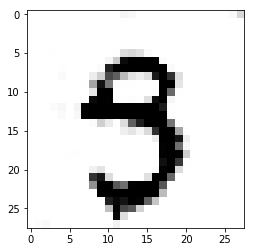

Estimate: [[ 0.91023093]]
Iteration: 38500 at 2018-02-23 18:35:48.650378


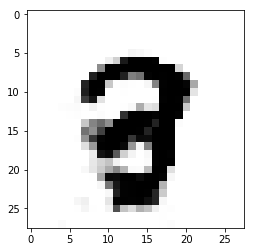

Estimate: [[-2.36100864]]
Iteration: 38600 at 2018-02-23 18:36:01.163864


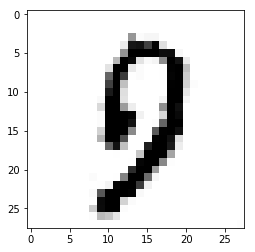

Estimate: [[ 1.69506693]]
Iteration: 38700 at 2018-02-23 18:36:13.717202


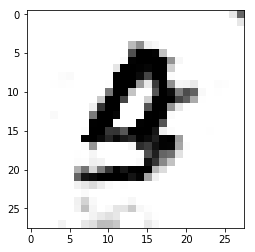

Estimate: [[-0.19198805]]
Iteration: 38800 at 2018-02-23 18:36:26.407523


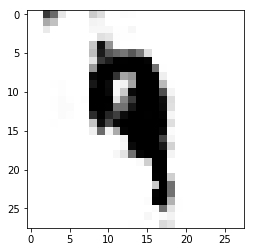

Estimate: [[ 3.8511672]]
Iteration: 38900 at 2018-02-23 18:36:38.919724


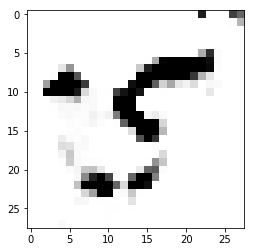

Estimate: [[-2.85001588]]
Iteration: 39000 at 2018-02-23 18:36:51.319010


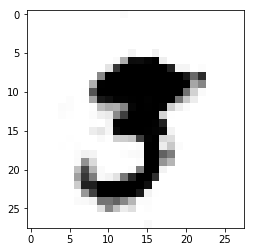

Estimate: [[-1.68800759]]
Iteration: 39100 at 2018-02-23 18:37:03.894867


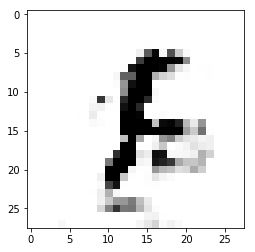

Estimate: [[-1.514364]]
Iteration: 39200 at 2018-02-23 18:37:16.322533


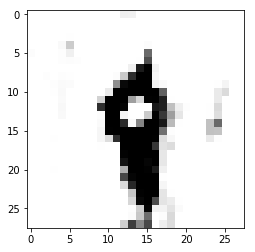

Estimate: [[-3.54964852]]
Iteration: 39300 at 2018-02-23 18:37:28.996651


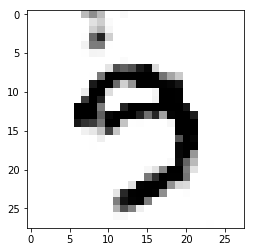

Estimate: [[-0.72604907]]
Iteration: 39400 at 2018-02-23 18:37:41.540838


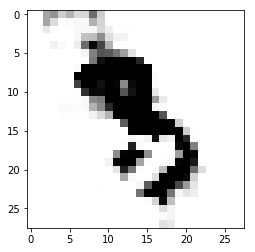

Estimate: [[ 1.53807747]]
Iteration: 39500 at 2018-02-23 18:37:54.193195


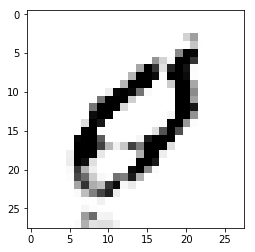

Estimate: [[-1.00222552]]
Iteration: 39600 at 2018-02-23 18:38:06.942511


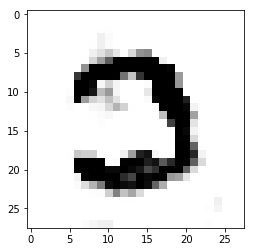

Estimate: [[-2.18850017]]
Iteration: 39700 at 2018-02-23 18:38:19.565261


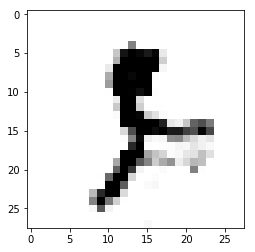

Estimate: [[-0.39704868]]
Iteration: 39800 at 2018-02-23 18:38:32.019558


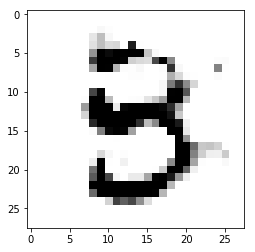

Estimate: [[-1.9096272]]
Iteration: 39900 at 2018-02-23 18:38:44.451218


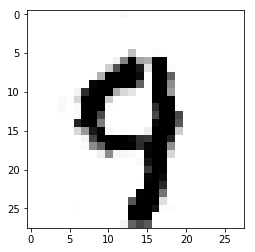

Estimate: [[ 1.13124382]]
Iteration: 40000 at 2018-02-23 18:38:56.915629


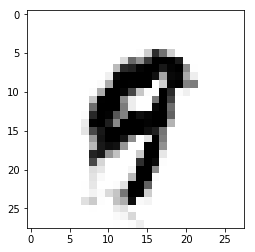

Estimate: [[-2.94093943]]
Iteration: 40100 at 2018-02-23 18:39:09.451784


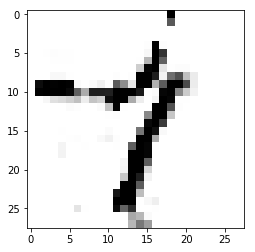

Estimate: [[ 1.41790628]]
Iteration: 40200 at 2018-02-23 18:39:22.161870


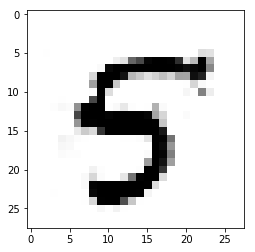

Estimate: [[ 2.12157035]]
Iteration: 40300 at 2018-02-23 18:39:34.998060


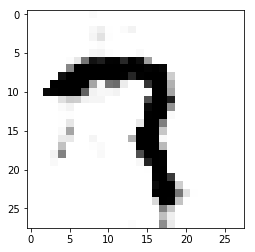

Estimate: [[-1.68359804]]
Iteration: 40400 at 2018-02-23 18:39:47.602850


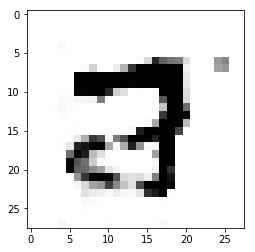

Estimate: [[-1.94456589]]
Iteration: 40500 at 2018-02-23 18:40:00.634832


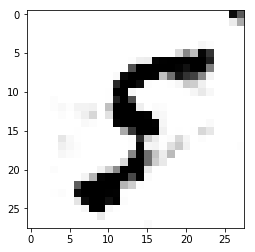

Estimate: [[-1.3321687]]
Iteration: 40600 at 2018-02-23 18:40:13.308793


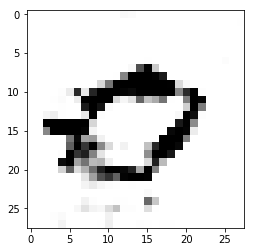

Estimate: [[ 0.13499686]]
Iteration: 40700 at 2018-02-23 18:40:26.045621


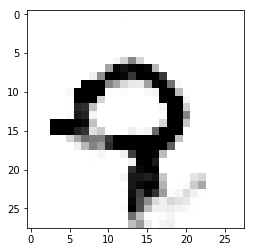

Estimate: [[ 1.97232556]]
Iteration: 40800 at 2018-02-23 18:40:38.917043


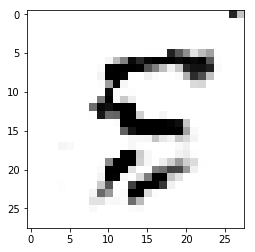

Estimate: [[ 0.27527034]]
Iteration: 40900 at 2018-02-23 18:40:51.552796


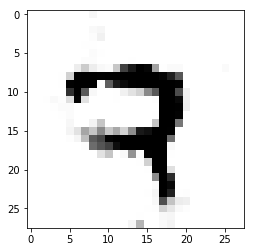

Estimate: [[ 0.68859184]]
Iteration: 41000 at 2018-02-23 18:41:04.397009


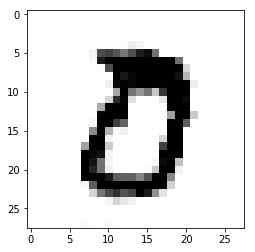

Estimate: [[-1.18056607]]
Iteration: 41100 at 2018-02-23 18:41:17.198065


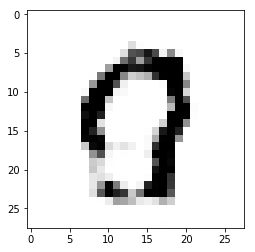

Estimate: [[ 0.39294016]]
Iteration: 41200 at 2018-02-23 18:41:30.003536


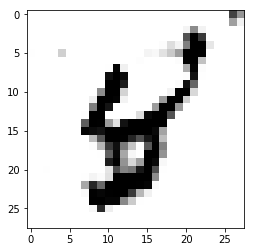

Estimate: [[ 0.27388316]]
Iteration: 41300 at 2018-02-23 18:41:42.793550


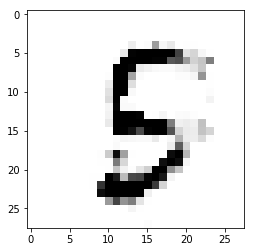

Estimate: [[-0.45726421]]
Iteration: 41400 at 2018-02-23 18:41:55.432468


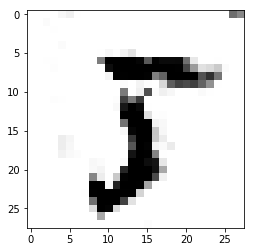

Estimate: [[ 0.27742356]]
Iteration: 41500 at 2018-02-23 18:42:08.364270


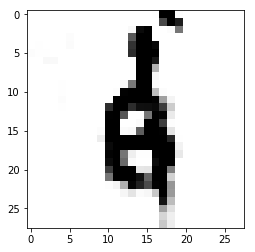

Estimate: [[ 1.05637705]]
Iteration: 41600 at 2018-02-23 18:42:21.180600


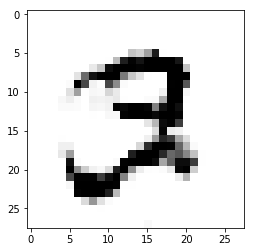

Estimate: [[-0.28674769]]
Iteration: 41700 at 2018-02-23 18:42:33.786088


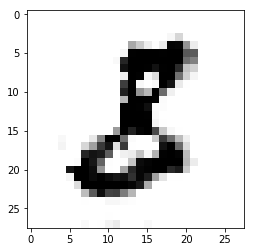

Estimate: [[-2.51006651]]
Iteration: 41800 at 2018-02-23 18:42:46.707697


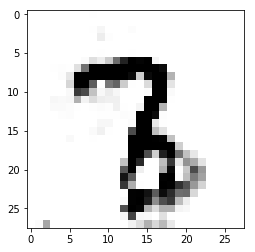

Estimate: [[ 1.5612967]]
Iteration: 41900 at 2018-02-23 18:42:59.381386


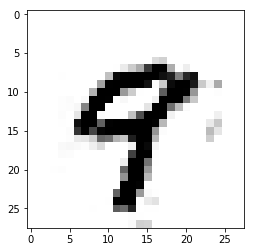

Estimate: [[-0.61615801]]
Iteration: 42000 at 2018-02-23 18:43:12.555406


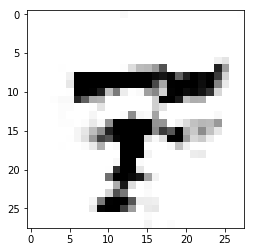

Estimate: [[ 1.48147619]]
Iteration: 42100 at 2018-02-23 18:43:25.269203


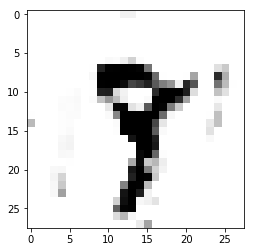

Estimate: [[-1.82102835]]
Iteration: 42200 at 2018-02-23 18:43:38.409133


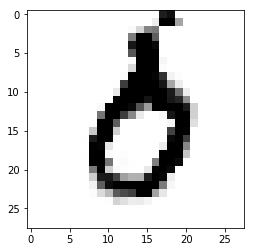

Estimate: [[-0.64998662]]
Iteration: 42300 at 2018-02-23 18:43:51.474523


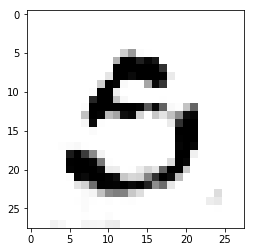

Estimate: [[-3.30843973]]
Iteration: 42400 at 2018-02-23 18:44:04.301714


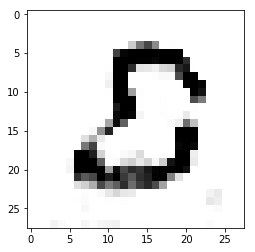

Estimate: [[-2.53400564]]
Iteration: 42500 at 2018-02-23 18:44:17.290724


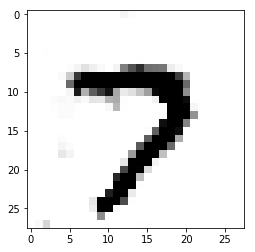

Estimate: [[ 3.37299013]]
Iteration: 42600 at 2018-02-23 18:44:30.373953


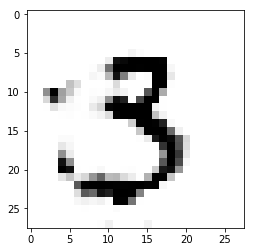

Estimate: [[ 0.59100974]]
Iteration: 42700 at 2018-02-23 18:44:43.015521


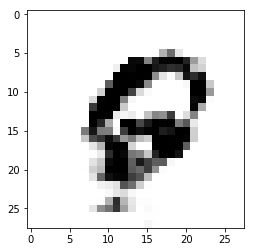

Estimate: [[-4.57434368]]
Iteration: 42800 at 2018-02-23 18:44:55.658899


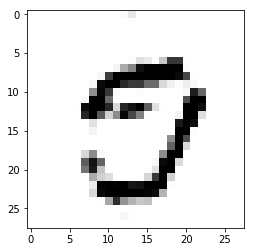

Estimate: [[-2.8407104]]
Iteration: 42900 at 2018-02-23 18:45:08.369605


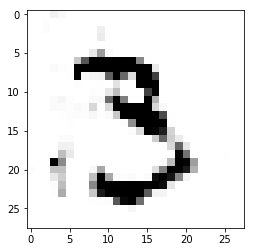

Estimate: [[-0.33483714]]
Iteration: 43000 at 2018-02-23 18:45:20.983995


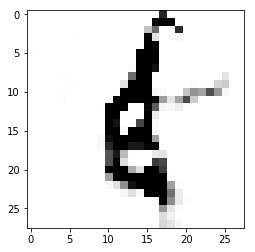

Estimate: [[ 0.12707242]]
Iteration: 43100 at 2018-02-23 18:45:33.834015


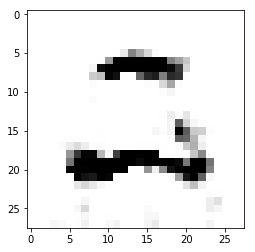

Estimate: [[-7.80691814]]
Iteration: 43200 at 2018-02-23 18:45:46.448394


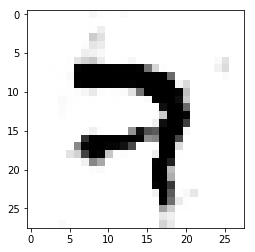

Estimate: [[ 2.90659022]]
Iteration: 43300 at 2018-02-23 18:45:58.976490


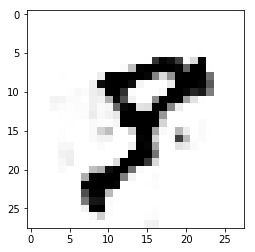

Estimate: [[ 1.17876327]]
Iteration: 43400 at 2018-02-23 18:46:11.708328


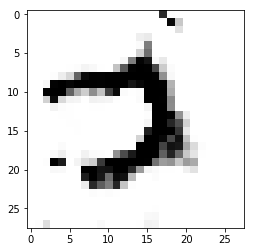

Estimate: [[-3.94802809]]
Iteration: 43500 at 2018-02-23 18:46:24.509878


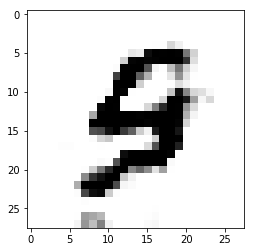

Estimate: [[-0.5200265]]
Iteration: 43600 at 2018-02-23 18:46:37.121786


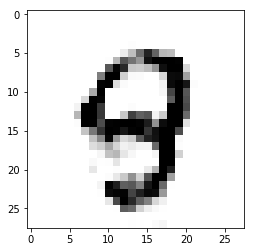

Estimate: [[ 1.66728997]]
Iteration: 43700 at 2018-02-23 18:46:49.980420


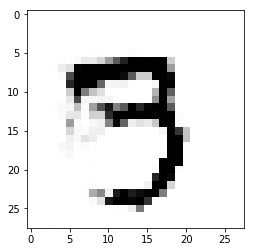

Estimate: [[ 0.83546275]]
Iteration: 43800 at 2018-02-23 18:47:03.664476


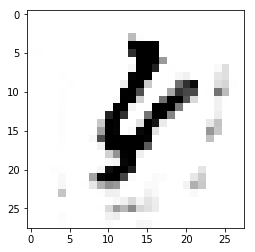

Estimate: [[-0.97984278]]
Iteration: 43900 at 2018-02-23 18:47:16.480280


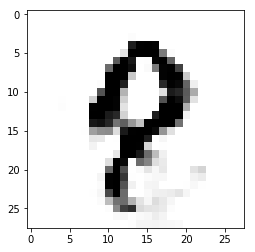

Estimate: [[-1.10308933]]
Iteration: 44000 at 2018-02-23 18:47:29.365565


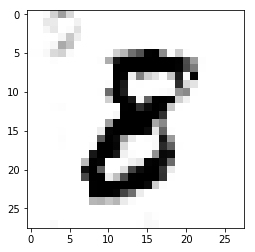

Estimate: [[ 0.98019499]]
Iteration: 44100 at 2018-02-23 18:47:42.018201


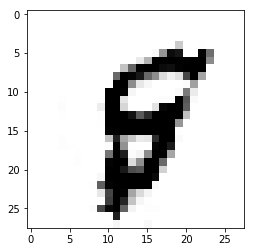

Estimate: [[-1.49930549]]
Iteration: 44200 at 2018-02-23 18:47:54.989739


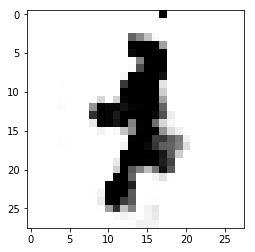

Estimate: [[ 2.27521229]]
Iteration: 44300 at 2018-02-23 18:48:07.906698


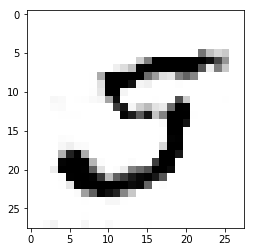

Estimate: [[-0.99512845]]
Iteration: 44400 at 2018-02-23 18:48:20.541933


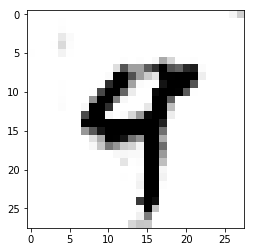

Estimate: [[-2.0067873]]
Iteration: 44500 at 2018-02-23 18:48:33.260303


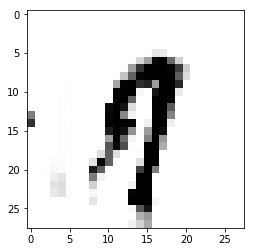

Estimate: [[-2.22202778]]
Iteration: 44600 at 2018-02-23 18:48:45.900495


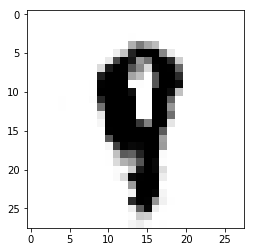

Estimate: [[ 0.31248271]]
Iteration: 44700 at 2018-02-23 18:48:58.888211


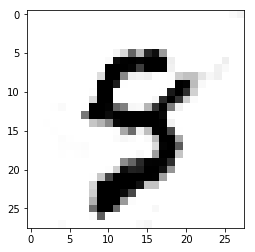

Estimate: [[-3.00079536]]
Iteration: 44800 at 2018-02-23 18:49:11.755677


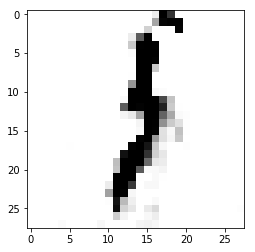

Estimate: [[ 0.05402113]]
Iteration: 44900 at 2018-02-23 18:49:24.791301


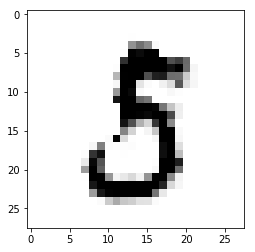

Estimate: [[-4.61998653]]
Iteration: 45000 at 2018-02-23 18:49:37.734140


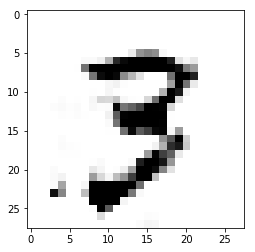

Estimate: [[-0.25671512]]
Iteration: 45100 at 2018-02-23 18:49:50.671157


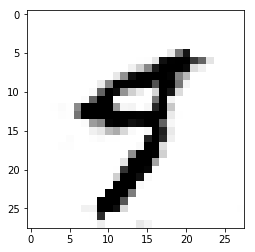

Estimate: [[ 0.54621422]]
Iteration: 45200 at 2018-02-23 18:50:03.832168


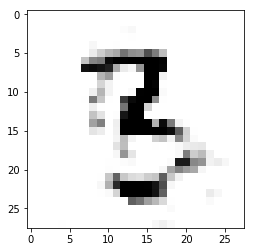

Estimate: [[ 0.49617273]]
Iteration: 45300 at 2018-02-23 18:50:16.655849


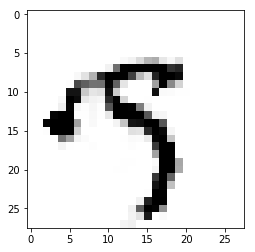

Estimate: [[-0.90047991]]
Iteration: 45400 at 2018-02-23 18:50:29.758165


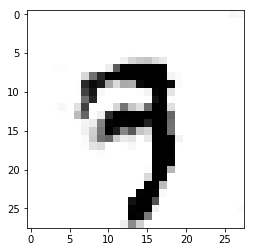

Estimate: [[ 0.05542226]]
Iteration: 45500 at 2018-02-23 18:50:42.819794


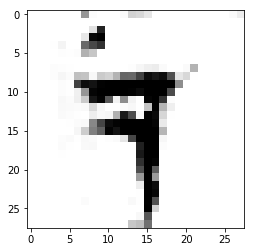

Estimate: [[-0.39128804]]
Iteration: 45600 at 2018-02-23 18:50:56.210715


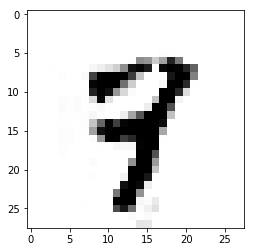

Estimate: [[ 0.29313391]]
Iteration: 45700 at 2018-02-23 18:51:09.463118


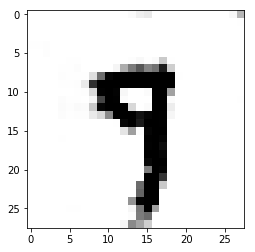

Estimate: [[ 1.52873695]]
Iteration: 45800 at 2018-02-23 18:51:22.275887


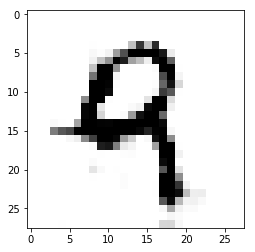

Estimate: [[ 0.48217088]]
Iteration: 45900 at 2018-02-23 18:51:35.065649


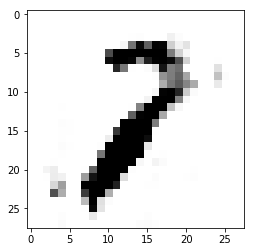

Estimate: [[-1.10774016]]
Iteration: 46000 at 2018-02-23 18:51:47.868141


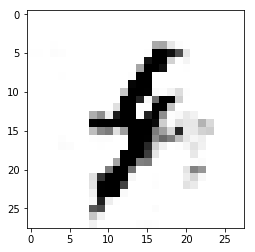

Estimate: [[ 0.9898147]]
Iteration: 46100 at 2018-02-23 18:52:00.513957


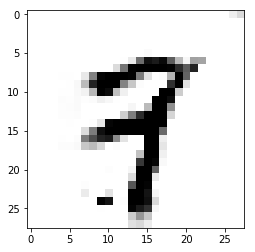

Estimate: [[ 1.39922142]]
Iteration: 46200 at 2018-02-23 18:52:13.221249


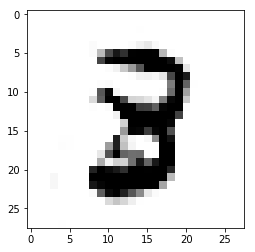

Estimate: [[ 0.38093686]]
Iteration: 46300 at 2018-02-23 18:52:25.948923


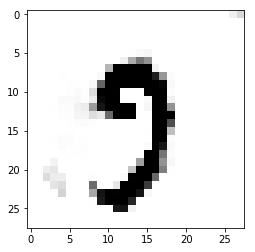

Estimate: [[ 1.83256757]]
Iteration: 46400 at 2018-02-23 18:52:39.105701


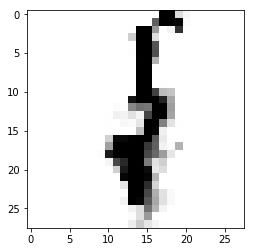

Estimate: [[-2.06879473]]
Iteration: 46500 at 2018-02-23 18:52:51.847961


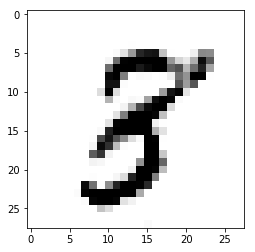

Estimate: [[ 1.44043589]]
Iteration: 46600 at 2018-02-23 18:53:04.950852


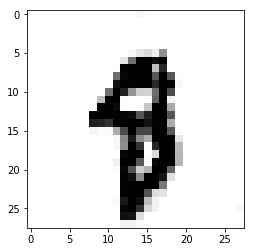

Estimate: [[ 1.67625499]]
Iteration: 46700 at 2018-02-23 18:53:17.608503


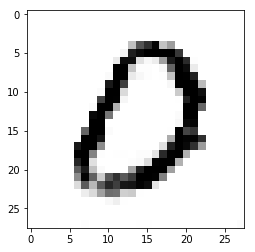

Estimate: [[ 5.71659088]]
Iteration: 46800 at 2018-02-23 18:53:30.481776


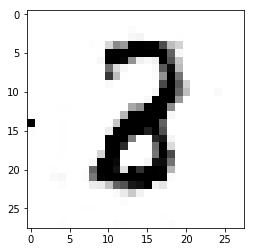

Estimate: [[ 0.11056708]]
Iteration: 46900 at 2018-02-23 18:53:43.308934


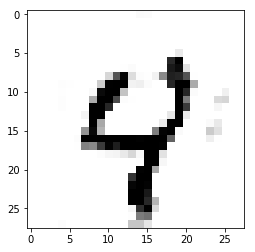

Estimate: [[ 0.43925297]]
Iteration: 47000 at 2018-02-23 18:53:56.291163


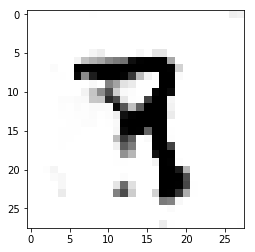

Estimate: [[-1.81224191]]
Iteration: 47100 at 2018-02-23 18:54:09.186076


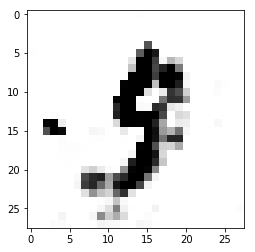

Estimate: [[-0.63132179]]
Iteration: 47200 at 2018-02-23 18:54:22.239386


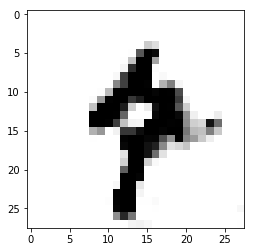

Estimate: [[ 1.35215688]]
Iteration: 47300 at 2018-02-23 18:54:35.608545


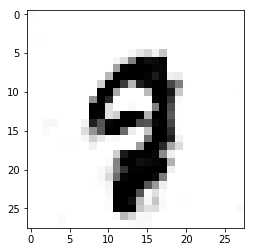

Estimate: [[-0.35317048]]


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

It can take very long to train a GAN.
In the following cell, we loads a model [pretrained_gan.ckpt](https://github.com/louispoweichen/GAN/blob/master/MNIST/pretrained_gan.ckpt)that we've already trained for several hours on with GPU, and lets us experiment with the output of a trained GAN.  
We can use the following command to use the pretrained model.  


In [8]:
"""
saver = tf.train.Saver()  
with tf.Session() as sess:  
    saver.restore(sess, 'pretrained_gan.ckpt')  
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])  
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')   
    generated_images = generator(z_placeholder, 10, z_dimensions)  
    images = sess.run(generated_images, {z_placeholder: z_batch})  
    for i in range(10):    
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()  
"""

"\nsaver = tf.train.Saver()  \nwith tf.Session() as sess:  \n    saver.restore(sess, 'pretrained_gan.ckpt')  \n    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])  \n    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')   \n    generated_images = generator(z_placeholder, 10, z_dimensions)  \n    images = sess.run(generated_images, {z_placeholder: z_batch})  \n    for i in range(10):    \n        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')\n        plt.show()  \n"